In [2]:
import matplotlib.pyplot as plt
import numpy as np
import networkx as nx
import statistics
import random
import tqdm
import copy
from matplotlib.pyplot import cm
import pandas as pd


## Limited Time Mitigation

This is added to allow for mitigation to be implemented than removed 

In [3]:
#START WITH JUST ADDING ONE THEN MAYBE TRU TO ALLOW FOR MORE LATER
#Just use list of lists with specific mitigation key as first parameter
#Then for each mitigation keep track of mitigating nodes
#Once mitigation is removed go through each mitigating node and divide weight by reduced probability

def sort_dic(dic):
    return sorted(dic.keys(), key=lambda x: dic[x][2], reverse=True)

li = 
dic = dict([(1, 0.5, 3, 4), (0.5, 0.5, 3, 6), (0.2, 0.3, 6, 9), (0.7, 0.8, 10, 11), (0.6, 0.1, 1, 12)])
print(sort_dic(dic))

ValueError: dictionary update sequence element #0 has length 4; 2 is required

  0%|                                                    | 0/10 [00:00<?, ?it/s]

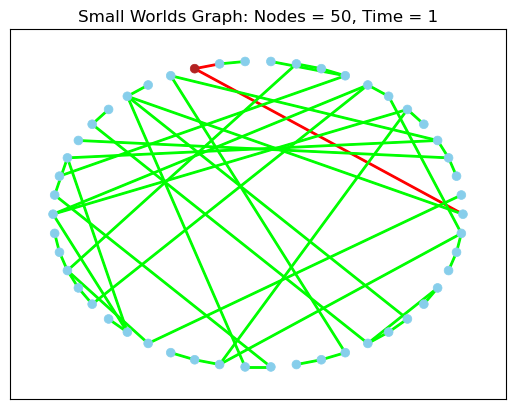

 10%|████▍                                       | 1/10 [00:00<00:01,  5.79it/s]

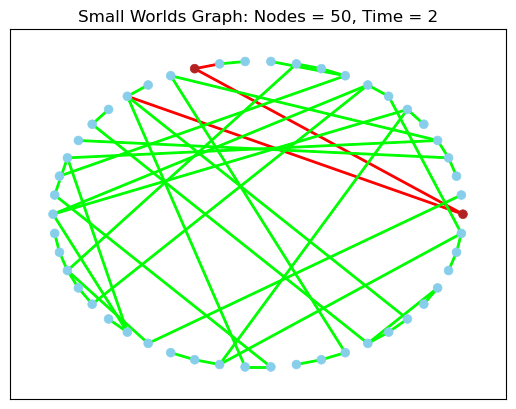

 20%|████████▊                                   | 2/10 [00:00<00:01,  6.70it/s]

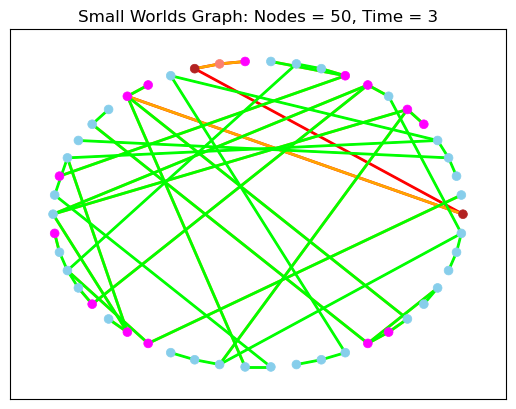

 30%|█████████████▏                              | 3/10 [00:00<00:00,  7.01it/s]

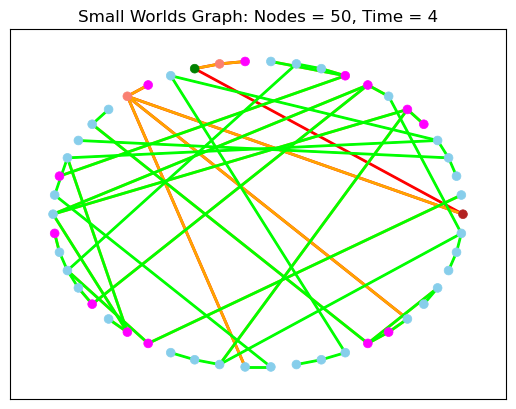

 40%|█████████████████▌                          | 4/10 [00:00<00:00,  7.03it/s]

 50%|██████████████████████                      | 5/10 [00:00<00:00,  7.33it/s]

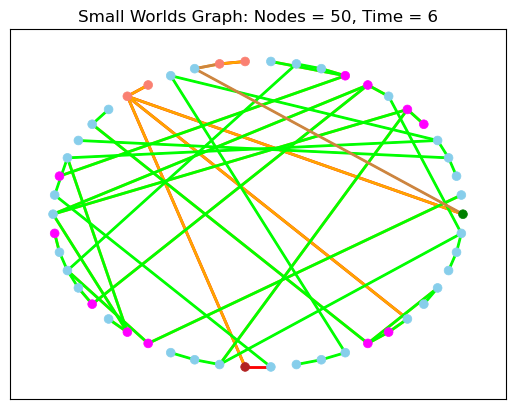

 60%|██████████████████████████▍                 | 6/10 [00:00<00:00,  7.42it/s]

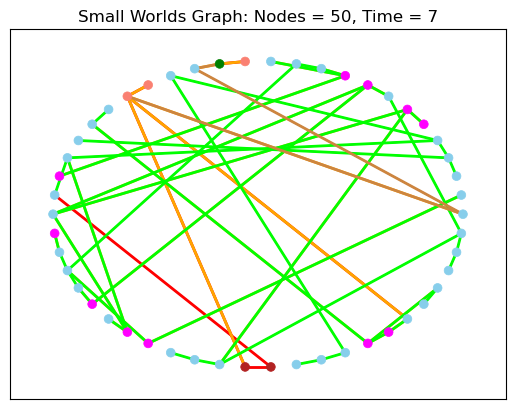

 70%|██████████████████████████████▊             | 7/10 [00:00<00:00,  7.54it/s]

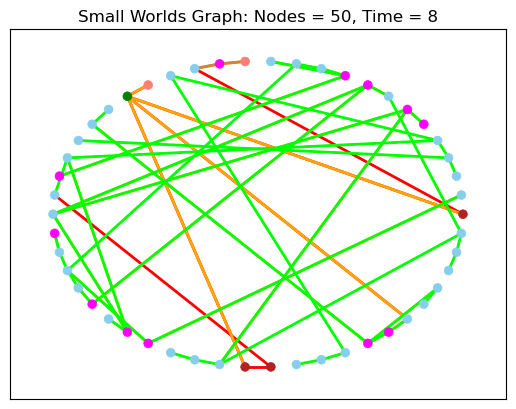

 80%|███████████████████████████████████▏        | 8/10 [00:01<00:00,  7.55it/s]

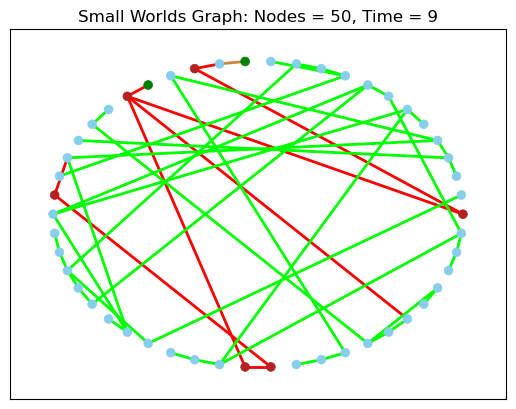

 90%|███████████████████████████████████████▌    | 9/10 [00:01<00:00,  7.58it/s]

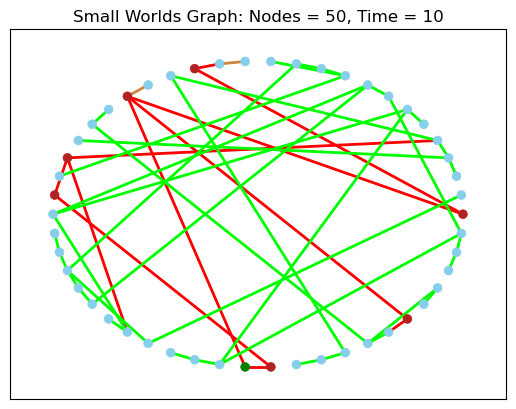

100%|███████████████████████████████████████████| 10/10 [00:01<00:00,  7.32it/s]


In [62]:
class Pandemic_Network():
    
    def __init__(self, network_type: str, nodes: int, pandemicprob: float, mitigation_info = None, NIP = 3, RP = 0, sicknode = 0, SW_connections = 3, SW_randomness = 0.5, SF_k = 1, plots = False, TTR = 15, cum_mit = False):
        '''
        mitigation_info - list: [Proportion that mitigate, Probability of mitigation not working, Start Time, 
                                End Time]. 
        sicknodes - number of sick nodes to begin with
        TTR - Time to recover
        RP - Reinfect Probability - probability of being susceptable to reinfection default is 0 i.e. no reinfection
        NIP - Non-Infectious Period
        cum_mit - whether two nodes mitigating reduces mitigation more than just one node mitigating. 
        '''

        if network_type == 'Ring': # default is a ring network
            self.g = nx.watts_strogatz_graph(n = nodes, k = SW_connections, p = 0, seed=None)
        elif network_type == 'Small World':
            self.g = nx.watts_strogatz_graph(n = nodes, k = SW_connections, p = SW_randomness, seed=None)
        elif network_type == 'Scale Free':
            self.g = nx.barabasi_albert_graph(n = nodes, m = SF_k, seed=None, initial_graph=None) # m = Number of edges to attach from a new node to existing nodes
        else:
            self.g = nx.erdos_renyi_graph(n = nodes, p = 0.5, seed=None, directed=False) # if network type not specified, then generate random graph (erdos renyi model)

        self.pos = nx.circular_layout(self.g)
        self.n = nodes
        self.t = 0
        self.p = pandemicprob
        self.want_plots = plots

        #Mitigations
        if mitigation_info != None:  # if mitigations
            self.mitstart = mitigation_info[2]
            self.mitend = mitigation_info[3]
            self.mitproportion = mitigation_info[0]
            self.p_effective = mitigation_info[1]
        
        self.mitigating = set([])
        self.cum_mit = cum_mit
        
        #Sick nodes
        self.sicknodes = set([random.randint(0, nodes-1) for i in range(sicknode)]) # randomly generate n number of sicknnode
        self.recovered = set([])
        self.TTR = TTR # days to recover, default is 15, customisable dependent on model
        
        #Reinfection
        self.NIP = NIP  # - doesn't actually make sense reinfection can occur anytime after infection
        self.RP = RP
        
        # initialise TTR
        initial_TTR_vals = [0 if i not in self.sicknodes else TTR + 1 for i in range(nodes)]
        initial_TTR_dict = {i:initial_TTR_vals[i] for i in range(nodes)}
        nx.set_node_attributes(self.g, initial_TTR_dict, name = 'TTR')
        
        # initialise RP
        initial_NIP_vals = [0 if i not in self.recovered else NIP + 1 for i in range(nodes)]
        initial_NIP_dict = {i:initial_NIP_vals[i] for i in range(nodes)}
        nx.set_node_attributes(self.g, initial_NIP_dict, name = 'NIP')
        # TO Perform reinfection - just introduce a new weight to allow reinfected edges. This weight can be 
        # the probability of infection normally * the probability of reinfection
        
        #Re 
        self.R = dict()
        for node in self.sicknodes:
            self.R[node] = 0 # initialise the infected nodes to having infected 0 other nodes
        self.Rt = []
    
    def plot(self):

        node_colors = ["green" if node in self.recovered else 'salmon' if node in self.mitigating and node in self.sicknodes else 'magenta' if node in self.mitigating else "firebrick" if node in self.sicknodes else "skyblue" for node in self.g.nodes()]
        nx.draw_networkx(self.g, pos = self.pos, with_labels=False, node_size=2000/self.n, node_color=node_colors, linewidths=0.5)

        e_no_mit = [(u, v) for (u, v, d) in self.g.edges(data=True) if d["weight"] == self.p]
        e_mit = [(u, v) for (u, v, d) in self.g.edges(data=True) if u in self.mitigating or v in self.mitigating]
        e_sus = [(u, v) for (u, v, d) in self.g.edges(data=True) if d["weight"] == 0]
        e_rp = [(u,v) for (u, v, d) in self.g.edges(data=True) if d["weight"] == self.p*self.RP]
        nx.draw_networkx_edges(self.g, self.pos, edgelist=e_no_mit, width=2, edge_color='red') # un-mitigating
        nx.draw_networkx_edges(self.g, self.pos, edgelist=e_mit, width=2, edge_color='orange') # mitigating
        nx.draw_networkx_edges(self.g, self.pos, edgelist=e_sus, width=2, edge_color='lime') # susceptible
        nx.draw_networkx_edges(self.g, self.pos, edgelist=e_rp, width=2, edge_color='peru') # Reinfected

        
        plt.title("Small Worlds Graph: Nodes = "+ str(self.n)+ ", Time = " + str(self.t))
        plt.show()
        return
    
    #def sicknode
    def propagate(self, steps: int):
        #Plot initial network
        # self.plot() 
        timestamps = []
        infectious_count = []
        recovery_count = []
        uninfected_count = []
        cumulative_case_count = []

        for time in tqdm.tqdm(range(steps)):
            #check sick nodes
            new_sick = 0
            timestamps.append(time)
            # print('Time = ', time)
            # print([self.g.nodes[i]['TTR'] for i in range(len(list(self.g.nodes)))])
            # print('Infectious:', self.sicknodes)
            # print('Recovered:', self.recovered)
            if time == 0:
                cumulative_case_count.append(len(self.sicknodes))

                # initialise edge weights
                edge_list = [(u, v) for (u, v, d) in self.g.edges(data = True)] # all edges
                for j in edge_list:
                    if (j[0] in self.sicknodes or j[1] in self.sicknodes):
                        self.g.add_edge(j[0], j[1], weight = self.p) 
                    else:
                        self.g.add_edge(j[0], j[1], weight = 0) 

                # self.plot()
                
            else: 
                pass
            
            if time == self.mitstart:
                while len(self.mitigating) < int(self.n*self.mitproportion):
                    self.mitigating.add(random.choice(list(self.g.nodes())))
                    
            if time == self.mitend:
                self.mitigating = []
                    
            infectious_count.append(len(self.sicknodes))
            recovery_count.append(len(self.recovered))
            uninfected_count.append(self.n - len(self.recovered) - len(self.sicknodes))
            
            currentsick = copy.copy(self.sicknodes) #as new sick nodes may be created and we don't want to loop through the new ones

            for i in range(len(list(self.g.nodes))):
                
                #Checking TTR
                if self.g.nodes[i]['TTR'] - 1 == 0: # end of infectious period
                    self.sicknodes.remove(i)
                    self.recovered.add(i)
                    nx.set_node_attributes(self.g, {i:self.NIP + 1}, name = 'NIP') # initialise infectious node
                    nx.set_node_attributes(self.g, {i: 0}, name='TTR') # decrement TTR value

                elif self.g.nodes[i]['TTR'] == 0: # not infectious, no action
                    pass
                else: # mid infectious period
                    nx.set_node_attributes(self.g, {i: self.g.nodes[i]['TTR'] - 1}, name='TTR') # decrement TTR value    
                    
                #Checking NIP
                if self.g.nodes[i]['NIP'] -1 == 0:
                    self.recovered.remove(i)
                    neighbours = list(self.g.neighbors(i))
                    for n in neighbours:
                        self.g.add_edge(i, n, weight = self.RP*self.p)  # after infection, new weights should be probability of infection * probability of reinfection

                    #if i in self.mitigating:
                    #    self.mitigating.remove(i)
                    #else:
                    #    pass
                    nx.set_node_attributes(self.g, {i: 0}, name='NIP') # decrement TTR value
                
                elif self.g.nodes[i]['NIP'] == 0: # not non-infectious period, no action
                    pass
                else:
                    nx.set_node_attributes(self.g, {i: self.g.nodes[i]['NIP'] - 1}, name='NIP') # decrement TTR value    

            
            for node in currentsick:
                neighbours = list(self.g.neighbors(node))

                #try to propagate sickness
                for neighbour in neighbours:
                        
                    if neighbour in self.sicknodes or neighbour in self.recovered: # do not infect again if already sick.
                        pass
                    elif node in self.mitigating or neighbour in self.mitigating:
                        if np.random.random() < self.g.get_edge_data(node,neighbour)['weight']*self.p_effective: # new node infected
                            self.sicknodes.add(neighbour)
                            adj_neighbours = list(self.g.neighbors(neighbour)) # access the neighbours of the newly infected node to create new edge weightings.
                            new_sick += 1

                            nx.set_node_attributes(self.g, {neighbour:self.TTR + 1}, name = 'TTR') # initialise infectious node

                            for i in adj_neighbours:    
                                self.g.add_edge(i, neighbour, weight = self.p)
                        
                    else: # node not infected
                        if np.random.random() < self.g.get_edge_data(node,neighbour)['weight']: # new node infected
                            self.sicknodes.add(neighbour)
                            adj_neighbours = list(self.g.neighbors(neighbour)) # access the neighbours of the newly infected node to create new edge weightings.
                            new_sick += 1

                            nx.set_node_attributes(self.g, {neighbour:self.TTR + 1}, name = 'TTR') # initialise infectious node

                            for i in adj_neighbours:    
                                self.g.add_edge(i, neighbour, weight = self.p)
            
            self.Rt.append((new_sick/len(currentsick))*5) # Can just calculate Rt using this as it is just ratio of new people infected with currently infected nodes
            cumulative_case_count.append(cumulative_case_count[-1] + new_sick)
            self.t += 1 #timestep increase by 1
            
            if self.want_plots: 
                self.plot()
                
            
            #If no more sick nodes than we can finish propagation
            if len(self.sicknodes) == 0:
                break
                
        # self.plot()             
        return timestamps, infectious_count, recovery_count, uninfected_count, cumulative_case_count[:-1], self.Rt
    
    
# Testing the class
num_nodes = 50
num_sick = 2
avg_connection = 3
randomness = 0.5
TTR_val = 3
NIP = 1
RP = 0.5
p = 0.6
mitigation = [0.3, 0.75, 2, 8]
RP = 0.5
ntype = 'Small World'

G_data = Pandemic_Network(network_type = ntype, nodes = num_nodes, pandemicprob = p, mitigation_info = mitigation, NIP = NIP, RP = RP, sicknode = 1, SW_connections = avg_connection, SW_randomness = randomness, plots = True, TTR = TTR_val).propagate(10)


## Limited Time Mitigation Analysis

Performing analysis on propagation class above

20 50  Repeat Number:  0


100%|█████████████████████████████████████████| 450/450 [13:46<00:00,  1.84s/it]


20 50  Repeat Number:  1


100%|███████████████████████████████████████| 450/450 [1:12:22<00:00,  9.65s/it]


20 50  Repeat Number:  2


100%|█████████████████████████████████████████| 450/450 [06:41<00:00,  1.12it/s]


20 50  Repeat Number:  3


100%|█████████████████████████████████████████| 450/450 [06:41<00:00,  1.12it/s]


20 50  Repeat Number:  4


100%|█████████████████████████████████████████| 450/450 [06:41<00:00,  1.12it/s]


20 50  Repeat Number:  5


100%|█████████████████████████████████████████| 450/450 [07:00<00:00,  1.07it/s]


20 50  Repeat Number:  6


100%|█████████████████████████████████████████| 450/450 [06:40<00:00,  1.12it/s]


20 50  Repeat Number:  7


100%|█████████████████████████████████████████| 450/450 [06:46<00:00,  1.11it/s]


20 50  Repeat Number:  8


100%|█████████████████████████████████████████| 450/450 [17:03<00:00,  2.27s/it]


20 50  Repeat Number:  9


100%|█████████████████████████████████████████| 450/450 [06:51<00:00,  1.09it/s]


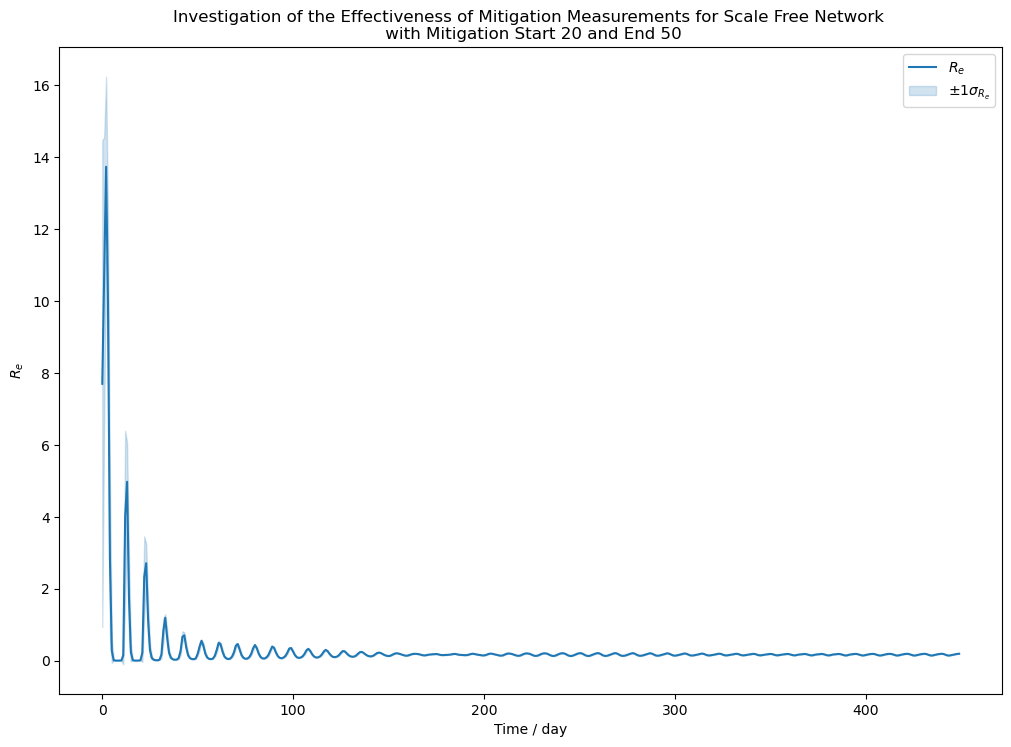

20 100  Repeat Number:  0


100%|█████████████████████████████████████████| 450/450 [06:58<00:00,  1.07it/s]


20 100  Repeat Number:  1


100%|█████████████████████████████████████████| 450/450 [06:52<00:00,  1.09it/s]


20 100  Repeat Number:  2


100%|█████████████████████████████████████████| 450/450 [06:47<00:00,  1.10it/s]


20 100  Repeat Number:  3


100%|█████████████████████████████████████████| 450/450 [06:49<00:00,  1.10it/s]


20 100  Repeat Number:  4


100%|█████████████████████████████████████████| 450/450 [06:47<00:00,  1.10it/s]


20 100  Repeat Number:  5


100%|█████████████████████████████████████████| 450/450 [06:46<00:00,  1.11it/s]


20 100  Repeat Number:  6


100%|█████████████████████████████████████████| 450/450 [45:55<00:00,  6.12s/it]


20 100  Repeat Number:  7


100%|█████████████████████████████████████████| 450/450 [06:37<00:00,  1.13it/s]


20 100  Repeat Number:  8


100%|█████████████████████████████████████████| 450/450 [06:52<00:00,  1.09it/s]


20 100  Repeat Number:  9


100%|█████████████████████████████████████████| 450/450 [06:48<00:00,  1.10it/s]


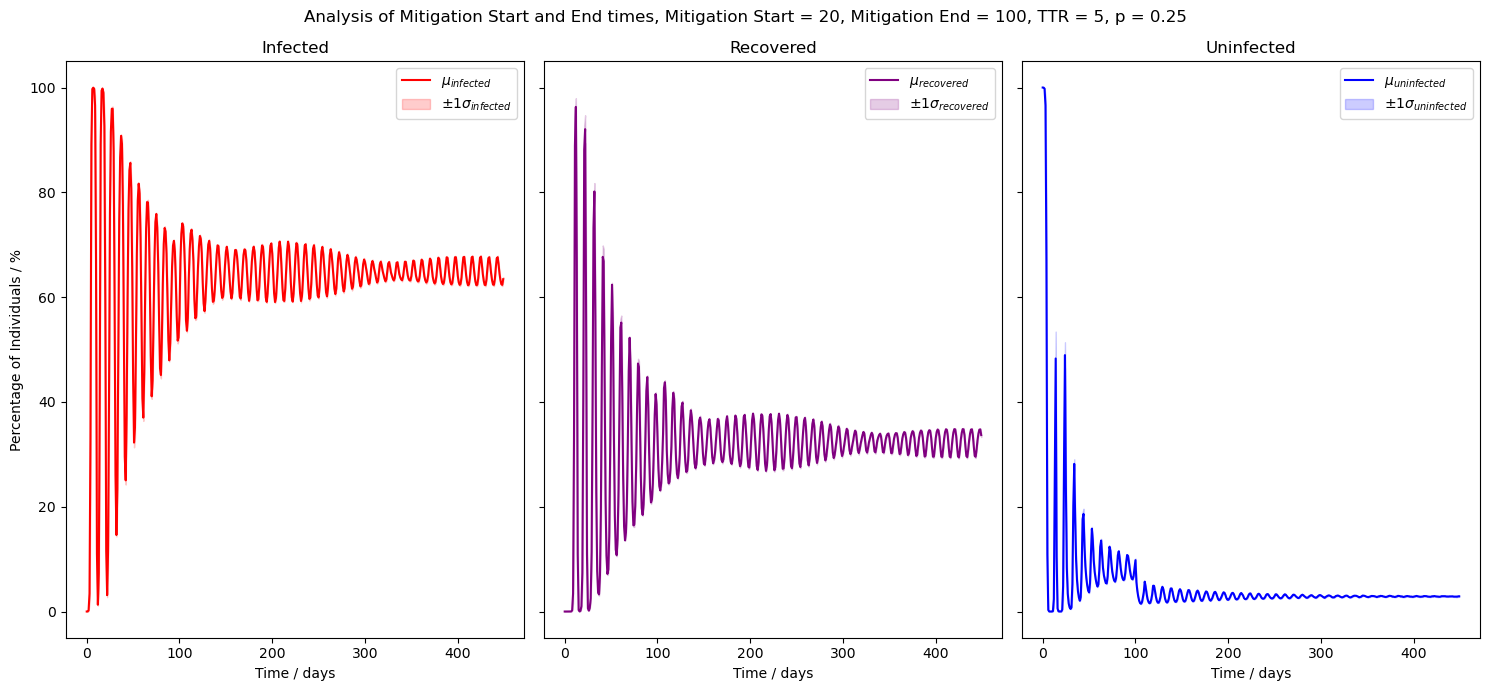

20 400  Repeat Number:  0


100%|█████████████████████████████████████████| 450/450 [06:52<00:00,  1.09it/s]


20 400  Repeat Number:  1


100%|█████████████████████████████████████████| 450/450 [06:55<00:00,  1.08it/s]


20 400  Repeat Number:  2


100%|█████████████████████████████████████████| 450/450 [07:01<00:00,  1.07it/s]


20 400  Repeat Number:  3


100%|█████████████████████████████████████████| 450/450 [07:05<00:00,  1.06it/s]


20 400  Repeat Number:  4


100%|███████████████████████████████████████| 450/450 [1:12:17<00:00,  9.64s/it]


20 400  Repeat Number:  5


100%|███████████████████████████████████████| 450/450 [1:52:29<00:00, 15.00s/it]


20 400  Repeat Number:  6


100%|█████████████████████████████████████████| 450/450 [06:50<00:00,  1.10it/s]


20 400  Repeat Number:  7


100%|█████████████████████████████████████████| 450/450 [07:17<00:00,  1.03it/s]


20 400  Repeat Number:  8


100%|███████████████████████████████████████| 450/450 [7:22:16<00:00, 58.97s/it]


20 400  Repeat Number:  9


100%|███████████████████████████████████████| 450/450 [5:24:12<00:00, 43.23s/it]


50 100  Repeat Number:  0


100%|█████████████████████████████████████████| 450/450 [07:22<00:00,  1.02it/s]


50 100  Repeat Number:  1


100%|█████████████████████████████████████████| 450/450 [08:02<00:00,  1.07s/it]


50 100  Repeat Number:  2


100%|█████████████████████████████████████████| 450/450 [07:28<00:00,  1.00it/s]


50 100  Repeat Number:  3


100%|█████████████████████████████████████████| 450/450 [07:05<00:00,  1.06it/s]


50 100  Repeat Number:  4


100%|█████████████████████████████████████████| 450/450 [06:54<00:00,  1.08it/s]


50 100  Repeat Number:  5


100%|█████████████████████████████████████████| 450/450 [06:53<00:00,  1.09it/s]


50 100  Repeat Number:  6


100%|█████████████████████████████████████████| 450/450 [07:04<00:00,  1.06it/s]


50 100  Repeat Number:  7


100%|█████████████████████████████████████████| 450/450 [06:52<00:00,  1.09it/s]


50 100  Repeat Number:  8


100%|█████████████████████████████████████████| 450/450 [06:46<00:00,  1.11it/s]


50 100  Repeat Number:  9


100%|█████████████████████████████████████████| 450/450 [06:50<00:00,  1.10it/s]


50 400  Repeat Number:  0


100%|█████████████████████████████████████████| 450/450 [07:01<00:00,  1.07it/s]


50 400  Repeat Number:  1


100%|█████████████████████████████████████████| 450/450 [07:07<00:00,  1.05it/s]


50 400  Repeat Number:  2


100%|█████████████████████████████████████████| 450/450 [07:10<00:00,  1.05it/s]


50 400  Repeat Number:  3


100%|█████████████████████████████████████████| 450/450 [06:53<00:00,  1.09it/s]


50 400  Repeat Number:  4


100%|█████████████████████████████████████████| 450/450 [07:01<00:00,  1.07it/s]


50 400  Repeat Number:  5


100%|█████████████████████████████████████████| 450/450 [07:09<00:00,  1.05it/s]


50 400  Repeat Number:  6


100%|█████████████████████████████████████████| 450/450 [07:16<00:00,  1.03it/s]


50 400  Repeat Number:  7


100%|█████████████████████████████████████████| 450/450 [06:56<00:00,  1.08it/s]


50 400  Repeat Number:  8


100%|█████████████████████████████████████████| 450/450 [07:13<00:00,  1.04it/s]


50 400  Repeat Number:  9


100%|█████████████████████████████████████████| 450/450 [07:02<00:00,  1.07it/s]


100 400  Repeat Number:  0


100%|█████████████████████████████████████████| 450/450 [06:53<00:00,  1.09it/s]


100 400  Repeat Number:  1


100%|█████████████████████████████████████████| 450/450 [06:53<00:00,  1.09it/s]


100 400  Repeat Number:  2


100%|█████████████████████████████████████████| 450/450 [06:46<00:00,  1.11it/s]


100 400  Repeat Number:  3


100%|█████████████████████████████████████████| 450/450 [07:17<00:00,  1.03it/s]


100 400  Repeat Number:  4


100%|█████████████████████████████████████████| 450/450 [06:57<00:00,  1.08it/s]


100 400  Repeat Number:  5


100%|█████████████████████████████████████████| 450/450 [30:42<00:00,  4.09s/it]


100 400  Repeat Number:  6


100%|███████████████████████████████████████| 450/450 [1:29:46<00:00, 11.97s/it]


100 400  Repeat Number:  7


100%|█████████████████████████████████████████| 450/450 [06:57<00:00,  1.08it/s]


100 400  Repeat Number:  8


100%|█████████████████████████████████████████| 450/450 [07:02<00:00,  1.07it/s]


100 400  Repeat Number:  9


100%|█████████████████████████████████████████| 450/450 [06:53<00:00,  1.09it/s]


In [72]:
# Testing the class
repeats = 10 
num_nodes = 50000
num_sick = 1
avg_connection = 6
randomness = 0.4
TTR_val = 5
NIP = 3
RP = 0.5
p = 0.25
mitprop = 0.3
miteffective = 0.25
starttime = [20, 50, 100]
endtime = [50, 100, 400]
mitigation = [0.3, 0.75, 2, 8]
RP = 0.5
ntype = ['Scale Free']
numsteps = 450

meaninfsf_df = pd.DataFrame(columns=list(range(numsteps)))
stdinfsf_df = pd.DataFrame(columns=list(range(numsteps)))
meanrecsf_df = pd.DataFrame(columns=list(range(numsteps)))
stdrecsf_df = pd.DataFrame(columns=list(range(numsteps)))
meanuninfsf_df = pd.DataFrame(columns=list(range(numsteps)))
stduninfsf_df = pd.DataFrame(columns=list(range(numsteps)))
meanRTsf_df = pd.DataFrame(columns=list(range(numsteps)))
stdRTsf_df = pd.DataFrame(columns=list(range(numsteps)))

for nettype in ntype:
    for start in starttime:
        for end in endtime:
            if start >= end:
                continue
                
            data_inf = []
            data_rec = []
            data_tot = []
            data_cum = []
            data_Re = []

            for i in range(repeats):
                print(start,end,' Repeat Number: ', i)
                G_data = Pandemic_Network(network_type = nettype, nodes = num_nodes, pandemicprob = p, mitigation_info = [mitprop, miteffective, start, end], NIP = NIP, RP = RP, sicknode = 1, SW_connections = avg_connection, SF_k = avg_connection*2, SW_randomness = randomness, plots = False, TTR = TTR_val).propagate(numsteps)
                # timestamps.append(G_data[0])
                data_inf.append(G_data[1])
                data_rec.append(G_data[2])
                data_tot.append(G_data[3])
                data_cum.append(G_data[4])
                data_Re.append(G_data[5])

            data_inf_std = []
            data_inf_mean = []

            data_rec_std = []
            data_rec_mean = []

            data_tot_std = []
            data_tot_mean = []
            
            data_Re_std = []
            data_Re_mean = []

            for i in range(numsteps):
                data_inf_std.append(statistics.stdev([data_inf[j][i] if i < len(data_inf[j]) else 0 for j in range(repeats)]))
                data_inf_mean.append(statistics.mean([data_inf[j][i] if i < len(data_inf[j]) else 0 for j in range(repeats)]))

                data_rec_std.append(statistics.stdev([data_rec[j][i] if i < len(data_inf[j]) else 0 for j in range(repeats)]))
                data_rec_mean.append(statistics.mean([data_rec[j][i] if i < len(data_inf[j]) else 0 for j in range(repeats)]))

                data_tot_std.append(statistics.stdev([data_tot[j][i] if i < len(data_inf[j]) else 0 for j in range(repeats)]))
                data_tot_mean.append(statistics.mean([data_tot[j][i] if i < len(data_inf[j]) else 0 for j in range(repeats)]))
                
                data_Re_std.append(statistics.stdev([data_Re[j][i] if i < len(data_inf[j]) else 0 for j in range(repeats)]))
                data_Re_mean.append(statistics.mean([data_Re[j][i] if i < len(data_inf[j]) else 0 for j in range(repeats)]))
                
            meaninf_df.loc[len(meaninf_df)] = data_inf_mean
            stdinf_df.loc[len(stdinf_df)] = data_inf_std
            
            meanrec_df.loc[len(meanrec_df)] = data_rec_mean
            stdrec_df.loc[len(stdrec_df)] = data_rec_std
            
            meanuninf_df.loc[len(meanuninf_df)] = data_tot_mean
            stduninf_df.loc[len(stduninf_df)] = data_tot_std
            
            meanRT_df.loc[len(meanRT_df)] = data_Re_mean
            stdRT_df.loc[len(stdRT_df)] = data_Re_std

            data_inf_low = np.array([data_inf_mean[i] - data_inf_std[i] for i in range(len(data_inf_std))])
            data_inf_high = np.array([data_inf_mean[i] + data_inf_std[i] for i in range(len(data_inf_std))])

            data_rec_low = np.array([data_rec_mean[i] - data_rec_std[i] for i in range(len(data_rec_std))])
            data_rec_high = np.array([data_rec_mean[i] + data_rec_std[i] for i in range(len(data_rec_std))])

            data_tot_low = np.array([data_tot_mean[i] - data_tot_std[i] for i in range(len(data_tot_std))])
            data_tot_high = np.array([data_tot_mean[i] + data_tot_std[i] for i in range(len(data_tot_std))])
            
            data_Re_low = np.array([data_Re_mean[i] - data_Re_std[i] for i in range(len(data_Re_std))])
            data_Re_high = np.array([data_Re_mean[i] + data_Re_std[i] for i in range(len(data_Re_std))])

            timestamps = [i for i in range(len(data_inf_mean))]

            fig, ax = plt.subplots(nrows = 1, ncols = 3, sharey = True, sharex = True, figsize = (15,7))

            ax[0].plot(timestamps,np.array(data_inf_mean)/num_nodes*100, color = 'red', label = '$\mu_{infected}$')
            ax[1].plot(timestamps,np.array(data_rec_mean)/num_nodes*100, color = 'purple', label = '$\mu_{recovered}$')
            ax[2].plot(timestamps,np.array(data_tot_mean)/num_nodes*100, color = 'blue', label = '$\mu_{uninfected}$')

            ax[0].fill_between(timestamps, data_inf_low/num_nodes*100, data_inf_high/num_nodes*100, alpha = 0.2, color = 'red', label = '$ \pm 1\sigma_{infected}$')
            ax[1].fill_between(timestamps, data_rec_low/num_nodes*100, data_rec_high/num_nodes*100, alpha = 0.2, color = 'purple', label = '$ \pm 1\sigma_{recovered}$')
            ax[2].fill_between(timestamps, data_tot_low/num_nodes*100, data_tot_high/num_nodes*100, alpha = 0.2, color = 'blue', label = '$ \pm 1\sigma_{uninfected}$')

            fig.suptitle('Analysis of Mitigation Start and End times, Mitigation Start = {}, Mitigation End = {}, TTR = {}, p = {}'.format(start, end, TTR_val, p))
            ax[0].set_title('Infected')
            ax[1].set_title('Recovered')
            ax[2].set_title('Uninfected')

            ax[0].set_ylabel('Percentage of Individuals / %')
            ax[0].set_xlabel('Time / days')
            ax[1].set_xlabel('Time / days')
            ax[2].set_xlabel('Time / days')

            ax[0].legend()
            ax[1].legend()
            ax[2].legend()
            plt.tight_layout()
            plt.show()
            
            plt.figure(figsize = (10,7))
            plt.plot(timestamps, data_Re_mean, color = 'tab:blue', label = r'$R_e$')
            plt.fill_between(timestamps, data_Re_low, data_Re_high, alpha = 0.2, color = 'tab:blue', label = '$ \pm 1\sigma_{R_e}$')
            plt.legend()
            plt.tight_layout()
            plt.xlabel('Time / day')
            plt.ylabel(r'$R_e$')
            plt.title('Investigation of the Effectiveness of Mitigation Measurements for {} Network \n with Mitigation Start {} and End {}'.format(nettype, start, end))
            plt.show()

In [75]:
# Save Datasets
display(meaninf_df)
meaninf_df.to_csv('SW_MeanInfected_MitigationStartend')
stdinf_df.to_csv('SW_errorInfected_MitigationStartend')
meanrec_df.to_csv('SW_MeanRecovered_MitigationStartend')
stdrec_df.to_csv('SW_errorRecovered_MitigationStartend')
meanuninf_df.to_csv('SW_MeanNoninfected_MitigationStartend')
stduninf_df.to_csv('SW_errorNoninfected_MitigationStartend')
meanRT_df.to_csv('SW_MeanRe_MitigationStartend')
stdRT_df.to_csv('SW_errorRe_MitigationStartend')

meaninfsf_df.to_csv('SF_MeanInfected_MitigationStartend')
stdinfsf_df.to_csv('SF_errorInfected_MitigationStartend')
meanrecsf_df.to_csv('SF_MeanRecovered_MitigationStartend')
stdrecsf_df.to_csv('SF_errorRecovered_MitigationStartend')
meanuninfsf_df.to_csv('SF_MeanNoninfected_MitigationStartend')
stduninfsf_df.to_csv('SF_errorNoninfected_MitigationStartend')
meanRTsf_df.to_csv('SF_MeanRe_MitigationStartend')
stdRTsf_df.to_csv('SF_errorRe_MitigationStartend')

0     1      2       3        4        5        6        7        8    \
0   1.0   2.3    4.1     7.8     11.8     19.3     39.4     74.4    147.3   
1   1.0   2.5    5.6    11.2     19.0     31.5     50.2     81.6    127.6   
2   1.0   3.0    5.6    11.8     19.9     34.9     56.3     89.2    141.7   
3   1.0   2.8    5.6    11.1     18.4     31.2     50.4     80.7    130.1   
4   1.0   2.7    5.7    11.9     20.6     34.8     55.1     89.9    147.1   
5   1.0   2.7    6.8    13.9     21.4     32.9     52.2     83.6    132.9   
6   1.0   2.5    6.1    12.0     18.7     29.7     45.7     75.2    119.2   
7   1.0   2.4    5.2    11.1     22.8     42.9     68.6    107.2    174.7   
8   1.0   2.9    5.7    11.9     25.1     48.5     77.3    123.8    195.9   
9   1.0   2.2    4.8     9.8     18.9     36.2     57.0     91.0    146.6   
10  1.0   2.6    6.6    13.5     28.1     55.1     84.5    132.5    210.3   
11  1.0   3.1    7.6    16.6     33.9     70.1    111.9    178.1    281.3   
12  1.0   2.0    4.1     9.0     18.5     35.6     57.0     90.5    145.3   
13  1.0   3.0    6.8    13.8     25.6     49.6     94.3    177.7    340.6   
14  1.0   2.6    5.0     9.8     19.7     38.1     71.5    139.4    265.4   
15  1.0   2.4    5.3    12.0     25.1     48.3     91.1    179.6    340.6   
16  1.0   3.3    7.1    14.5     29.1     57.1    109.8    210.0    407.1   
17  1.0   2.7    5.9    11.2     23.1     47.9     93.5    182.2    353.7   
18  1.0   2.3    4.6     9.4     18.8     38.1     75.2    146.6    280.4   
19  1.0   3.0    6.6    14.1     28.3     54.5    104.7    199.1    390.1   
20  1.0   2.8    5.4    10.7     21.2     42.1     79.1    153.2    300.4   
21  1.0   2.5    5.2    10.3     20.5     40.3     77.9    151.9    295.7   
22  1.0   2.5    4.7     9.9     22.4     44.9     86.6    166.2    320.0   
23  1.0   2.0    4.9     9.5     20.4     40.4     78.0    149.9    289.3   
24  1.0   2.5    5.5    10.3     20.8     42.4     80.9    154.6    299.2   
25  1.0   2.6    5.9    11.2     21.6     40.9     79.3    151.6    292.4   
26  1.0   2.4    5.2    11.1     21.5     41.4     80.1    153.0    295.4   
27  1.0   3.1    7.0    13.2     26.0     50.4     98.8    193.3    370.3   
28  1.0   2.5    5.8    12.2     24.4     47.4     93.2    178.5    342.6   
29  1.0   1.5    3.8     7.9     14.9     29.2     57.1    113.4    216.3   
30  1.0   2.3    4.6     8.8     16.3     31.4     60.5    120.9    231.0   
31  1.0   2.7    6.5    14.9     30.1     59.2    115.0    216.1    418.1   
32  1.0   1.6    2.7     5.9     11.1     17.0     31.8     52.1     74.7   
33  1.0   1.2    1.5     2.2      2.6      3.3      3.0      3.9      4.8   
34  1.0   1.3    2.0     6.0     10.4     16.7     22.9     31.1     42.8   
35  1.0   1.4    3.4     6.3      8.4     11.5     13.5     18.1     20.9   
36  1.0   1.5    1.9     2.9      3.2      3.7      3.2      2.9      2.9   
37  1.0   6.7   62.9   850.8   7047.6  27506.9  48321.4  49953.8  49936.1   
38  1.0  14.9  259.6  2893.3  11553.3  31230.4  44655.7  48202.7  49059.7   
39  1.0   4.6   91.1  1381.1   9010.7  28656.4  43354.0  47864.7  49103.9   
40  1.0   6.8   70.9  1187.7   8964.2  30066.0  44019.3  48042.8  49195.6   
41  1.0   5.7   50.4   723.4   8730.2  36882.9  49368.6  49980.2  49949.3   
42  1.0   8.7  110.2  1602.0  14677.5  40917.9  49530.2  49981.8  49889.5   
43  1.0   6.4  113.0  1704.9  16482.6  44557.5  49855.1  49989.3  49886.8   
44  1.0   5.0   62.5  1123.2  11658.4  39441.4  49522.8  49983.1  49937.0   
45  1.0   6.5  146.8  2130.9  15188.7  39404.1  49300.2  49975.4  49852.7   
46  1.0   5.0   50.6  1001.6  10773.5  36381.0  47655.4  49890.8  49946.3   
47  1.0   5.7   60.9   861.3   9991.9  38271.9  49475.7  49982.0  49938.7   

        9    ...      440      441      442      443      444      445  \
0     285.6  ...  27902.3  27986.2  28072.9  28111.5  28148.0  28155.7   
1     208.8  ...  27993.6  28029.5  28108.2  28132.6  28188.8  28193.3   
2     22

## Directional Mitigation

To adjust to propagation to allow for directional mitigation probabilities

  0%|                                                    | 0/10 [00:00<?, ?it/s]

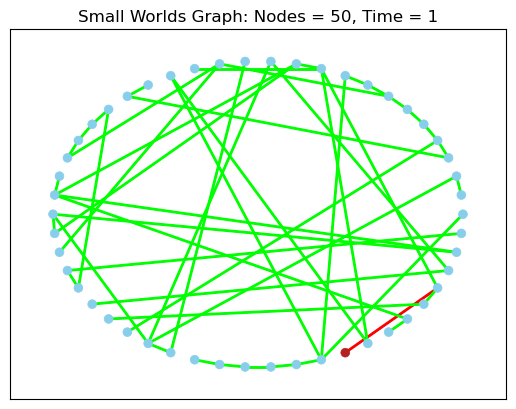

 10%|████▍                                       | 1/10 [00:00<00:01,  8.45it/s]

 20%|████████▊                                   | 2/10 [00:00<00:00,  8.40it/s]

 30%|█████████████▏                              | 3/10 [00:00<00:00,  8.30it/s]

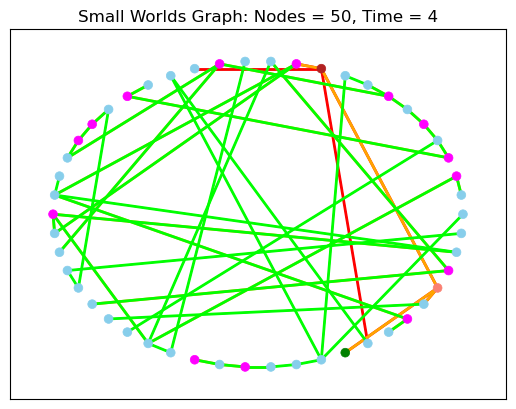

 40%|█████████████████▌                          | 4/10 [00:00<00:00,  8.24it/s]

 50%|██████████████████████                      | 5/10 [00:00<00:00,  7.97it/s]

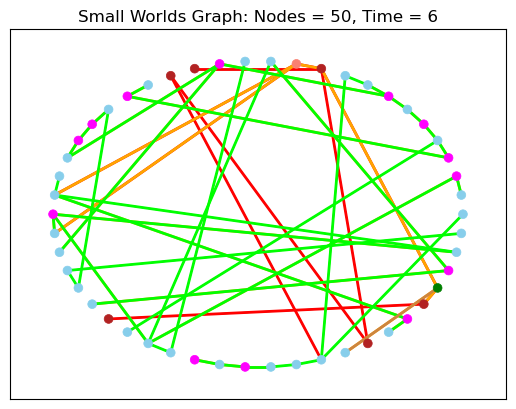

 60%|██████████████████████████▍                 | 6/10 [00:00<00:00,  7.84it/s]

 70%|██████████████████████████████▊             | 7/10 [00:00<00:00,  7.75it/s]

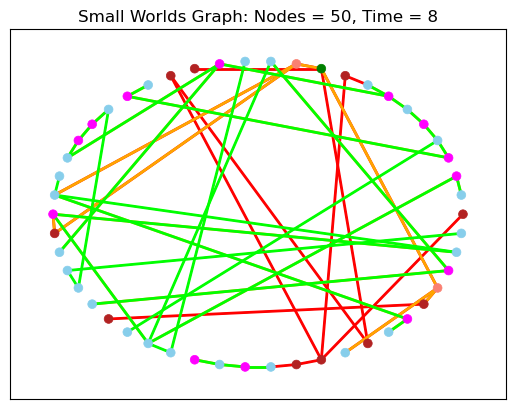

 80%|███████████████████████████████████▏        | 8/10 [00:01<00:00,  7.70it/s]

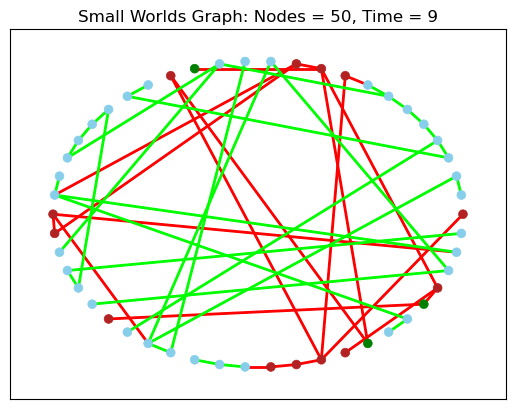

 90%|███████████████████████████████████████▌    | 9/10 [00:01<00:00,  7.88it/s]

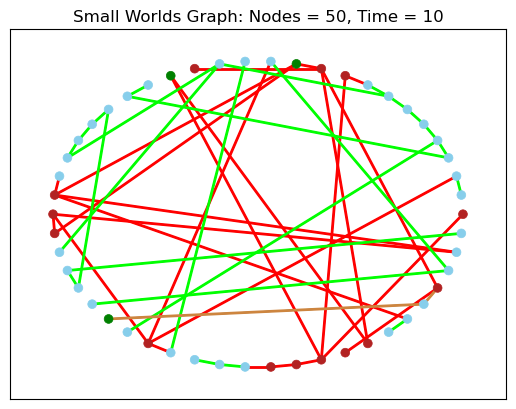

100%|███████████████████████████████████████████| 10/10 [00:01<00:00,  7.97it/s]


In [45]:
# Do this by checking for tuple, if mitigation probability is tuple than mitigation is directional

class Pandemic_Network():
    
    def __init__(self, network_type: str, nodes: int, pandemicprob: float, mitigation_info = None, NIP = 3, RP = 0, sicknode = 0, SW_connections = 3, SW_randomness = 0.5, SF_k = 1, plots = False, TTR = 15, cum_mit = False):
        '''
        mitigation_info - list: [Proportion that mitigate, Probability of mitigation not working, Start Time, 
                                End Time]. If probability of mitigation not working is a tuple, then implement 
                                directional mitigation. The first value in tuple is for healthy and second is 
                                for infected node.
        sicknodes - number of sick nodes to begin with
        TTR - Time to recover
        RP - Reinfect Probability - probability of being susceptable to reinfection default is 0 i.e. no reinfection
        NIP - Non-Infectious Period
        '''

        if network_type == 'Ring': # default is a ring network
            self.g = nx.watts_strogatz_graph(n = nodes, k = SW_connections, p = 0, seed=None)
        elif network_type == 'Small World':
            self.g = nx.watts_strogatz_graph(n = nodes, k = SW_connections, p = SW_randomness, seed=None)
        elif network_type == 'Scale Free':
            self.g = nx.barabasi_albert_graph(n = nodes, m = SF_k, seed=None, initial_graph=None) # m = Number of edges to attach from a new node to existing nodes
        else:
            self.g = nx.erdos_renyi_graph(n = nodes, p = 0.5, seed=None, directed=False) # if network type not specified, then generate random graph (erdos renyi model)

        self.pos = nx.circular_layout(self.g)
        self.n = nodes
        self.t = 0
        self.p = pandemicprob
        self.want_plots = plots

        #Mitigations
        if mitigation_info != None:  # if mitigations
            self.mitstart = mitigation_info[2]
            self.mitend = mitigation_info[3]
            self.mitproportion = mitigation_info[0]
            if type(mitigation_info[1]) == tuple:
                self.p_effective_healthy, self.p_effective_infected = mitigation_info[1]
                self.directional = True
            else:
                self.p_effective = mitigation_info[1]
                self.directional = False
        
        self.mitigating = set([])
        self.cum_mit = cum_mit

        
        #Sick nodes
        self.sicknodes = set([random.randint(0, nodes-1) for i in range(sicknode)]) # randomly generate n number of sicknnode
        self.recovered = set([])
        self.TTR = TTR # days to recover, default is 15, customisable dependent on model
        
        #Reinfection
        self.NIP = NIP  # 
        self.RP = RP
        
        # initialise TTR
        initial_TTR_vals = [0 if i not in self.sicknodes else TTR + 1 for i in range(nodes)]
        initial_TTR_dict = {i:initial_TTR_vals[i] for i in range(nodes)}
        nx.set_node_attributes(self.g, initial_TTR_dict, name = 'TTR')
        
        # initialise RP
        initial_NIP_vals = [0 if i not in self.recovered else NIP + 1 for i in range(nodes)]
        initial_NIP_dict = {i:initial_NIP_vals[i] for i in range(nodes)}
        nx.set_node_attributes(self.g, initial_NIP_dict, name = 'NIP')
        # TO Perform reinfection - just introduce a new weight to allow reinfected edges. This weight can be 
        # the probability of infection normally * the probability of reinfection
        
        #Re 
        self.R = dict()
        for node in self.sicknodes:
            self.R[node] = 0 # initialise the infected nodes to having infected 0 other nodes
        self.Rt = []
    
    def plot(self):

        node_colors = ["green" if node in self.recovered else 'salmon' if node in self.mitigating and node in self.sicknodes else 'magenta' if node in self.mitigating else "firebrick" if node in self.sicknodes else "skyblue" for node in self.g.nodes()]
        nx.draw_networkx(self.g, pos = self.pos, with_labels=False, node_size=2000/self.n, node_color=node_colors, linewidths=0.5)

        e_no_mit = [(u, v) for (u, v, d) in self.g.edges(data=True) if d["weight"] == self.p]
        e_mit = [(u, v) for (u, v, d) in self.g.edges(data=True) if u in self.mitigating or v in self.mitigating]
        e_sus = [(u, v) for (u, v, d) in self.g.edges(data=True) if d["weight"] == 0]
        e_rp = [(u,v) for (u, v, d) in self.g.edges(data=True) if d["weight"] == self.p*self.RP]
        nx.draw_networkx_edges(self.g, self.pos, edgelist=e_no_mit, width=2, edge_color='red') # un-mitigating
        nx.draw_networkx_edges(self.g, self.pos, edgelist=e_mit, width=2, edge_color='orange') # mitigating
        nx.draw_networkx_edges(self.g, self.pos, edgelist=e_sus, width=2, edge_color='lime') # susceptible
        nx.draw_networkx_edges(self.g, self.pos, edgelist=e_rp, width=2, edge_color='peru') # Reinfected

        
        plt.title("Small Worlds Graph: Nodes = "+ str(self.n)+ ", Time = " + str(self.t))
        plt.show()
        return
    
    #def sicknode
    def propagate(self, steps: int):
        #Plot initial network
        # self.plot() 
        if self.directional:
            timestamps = []
            infectious_count = []
            recovery_count = []
            uninfected_count = []
            cumulative_case_count = []

            for time in tqdm.tqdm(range(steps)):

                #check sick nodes
                new_sick = 0
                timestamps.append(time)
                # print('Time = ', time)
                # print([self.g.nodes[i]['TTR'] for i in range(len(list(self.g.nodes)))])
                # print('Infectious:', self.sicknodes)
                # print('Recovered:', self.recovered)
                if time == 0:
                    cumulative_case_count.append(len(self.sicknodes))

                    # initialise edge weights
                    edge_list = [(u, v) for (u, v, d) in self.g.edges(data = True)] # all edges
                    for j in edge_list:
                        if (j[0] in self.sicknodes or j[1] in self.sicknodes):
                            self.g.add_edge(j[0], j[1], weight = self.p) 
                        else:
                            self.g.add_edge(j[0], j[1], weight = 0) 


                else: 
                    pass

                if time == self.mitstart:
                    while len(self.mitigating) < int(self.n*self.mitproportion):
                        self.mitigating.add(random.choice(list(self.g.nodes())))

                if time == self.mitend:
                    self.mitigating = []

                infectious_count.append(len(self.sicknodes))
                recovery_count.append(len(self.recovered))
                uninfected_count.append(self.n - len(self.recovered) - len(self.sicknodes))

                currentsick = copy.copy(self.sicknodes) #as new sick nodes may be created and we don't want to loop through the new ones

                for i in range(len(list(self.g.nodes))):

                    #Checking TTR
                    if self.g.nodes[i]['TTR'] - 1 == 0: # end of infectious period
                        self.sicknodes.remove(i)
                        self.recovered.add(i)
                        nx.set_node_attributes(self.g, {i:self.NIP + 1}, name = 'NIP') # initialise infectious node
                        nx.set_node_attributes(self.g, {i: 0}, name='TTR') # decrement TTR value

                    elif self.g.nodes[i]['TTR'] == 0: # not infectious, no action
                        pass
                    else: # mid infectious period
                        nx.set_node_attributes(self.g, {i: self.g.nodes[i]['TTR'] - 1}, name='TTR') # decrement TTR value    

                    #Checking NIP
                    if self.g.nodes[i]['NIP'] -1 == 0:
                        self.recovered.remove(i)
                        neighbours = list(self.g.neighbors(i))
                        for n in neighbours:
                            self.g.add_edge(i, n, weight = self.RP*self.p)  # after infection, new weights should be probability of infection * probability of reinfection

                        #if i in self.mitigating:
                        #    self.mitigating.remove(i)
                        #else:
                        #    pass
                        nx.set_node_attributes(self.g, {i: 0}, name='NIP') # decrement TTR value

                    elif self.g.nodes[i]['NIP'] == 0: # not non-infectious period, no action
                        pass
                    else:
                        nx.set_node_attributes(self.g, {i: self.g.nodes[i]['NIP'] - 1}, name='NIP') # decrement TTR value    


                for node in currentsick:
                    neighbours = list(self.g.neighbors(node))

                    #try to propagate sickness
                    for neighbour in neighbours:
                        if neighbour in self.sicknodes or neighbour in self.recovered: # do not infect again if already sick.
                            pass
                        elif node in self.mitigating:
                            if np.random.random() < self.g.get_edge_data(node,neighbour)['weight']*self.p_effective_infected: # infected node mitigating
                                self.sicknodes.add(neighbour)
                                adj_neighbours = list(self.g.neighbors(neighbour)) # access the neighbours of the newly infected node to create new edge weightings.
                                new_sick += 1

                                nx.set_node_attributes(self.g, {neighbour:self.TTR + 1}, name = 'TTR') # initialise infectious node

                                for i in adj_neighbours:    
                                        self.g.add_edge(i, neighbour, weight = self.p)

                        elif neighbour in self.mitigating: # node did not adopt mitigation measure 
                            if np.random.random() < self.g.get_edge_data(node,neighbour)['weight']*self.p_effective_healthy: # healthy node mitigating
                                self.sicknodes.add(neighbour)
                                adj_neighbours = list(self.g.neighbors(neighbour)) # access the neighbours of the newly infected node to create new edge weightings.
                                new_sick += 1

                                nx.set_node_attributes(self.g, {neighbour:self.TTR + 1}, name = 'TTR') # initialise infectious node

                                for i in adj_neighbours:    
                                        self.g.add_edge(i, neighbour, weight = self.p)
                        else: # node not infected
                            if np.random.random() < self.g.get_edge_data(node,neighbour)['weight']:  # no node mitigating
                                self.sicknodes.add(neighbour)
                                adj_neighbours = list(self.g.neighbors(neighbour)) # access the neighbours of the newly infected node to create new edge weightings.
                                new_sick += 1

                                nx.set_node_attributes(self.g, {neighbour:self.TTR + 1}, name = 'TTR') # initialise infectious node

                                for i in adj_neighbours:    
                                        self.g.add_edge(i, neighbour, weight = self.p)

                self.Rt.append((new_sick/len(currentsick))*5) # Can just calculate Rt using this as it is just ratio of new people infected with currently infected nodes
                cumulative_case_count.append(cumulative_case_count[-1] + new_sick)
                self.t += 1 #timestep increase by 1

                if self.want_plots: 
                    self.plot()


                #If no more sick nodes than we can finish propagation
                if len(self.sicknodes) == 0:
                    break
                    
        else: # if not directed mitigation probability of effectiveness
            timestamps = []
            infectious_count = []
            recovery_count = []
            uninfected_count = []
            cumulative_case_count = []

            for time in tqdm.tqdm(range(steps)):
                #check sick nodes
                new_sick = 0
                timestamps.append(time)
                # print('Time = ', time)
                # print([self.g.nodes[i]['TTR'] for i in range(len(list(self.g.nodes)))])
                # print('Infectious:', self.sicknodes)
                # print('Recovered:', self.recovered)
                if time == 0:
                    cumulative_case_count.append(len(self.sicknodes))

                    # initialise edge weights
                    edge_list = [(u, v) for (u, v, d) in self.g.edges(data = True)] # all edges
                    for j in edge_list:
                        if (j[0] in self.sicknodes or j[1] in self.sicknodes):
                            self.g.add_edge(j[0], j[1], weight = self.p) 
                        else:
                            self.g.add_edge(j[0], j[1], weight = 0) 

                    # self.plot()

                else: 
                    pass

                if time == self.mitstart:
                    while len(self.mitigating) < int(self.n*self.mitproportion):
                        self.mitigating.add(random.choice(list(self.g.nodes())))

                if time == self.mitend:
                    self.mitigating = []

                infectious_count.append(len(self.sicknodes))
                recovery_count.append(len(self.recovered))
                uninfected_count.append(self.n - len(self.recovered) - len(self.sicknodes))

                currentsick = copy.copy(self.sicknodes) #as new sick nodes may be created and we don't want to loop through the new ones

                for i in range(len(list(self.g.nodes))):

                    #Checking TTR
                    if self.g.nodes[i]['TTR'] - 1 == 0: # end of infectious period
                        self.sicknodes.remove(i)
                        self.recovered.add(i)
                        nx.set_node_attributes(self.g, {i:self.NIP + 1}, name = 'NIP') # initialise infectious node
                        nx.set_node_attributes(self.g, {i: 0}, name='TTR') # decrement TTR value

                    elif self.g.nodes[i]['TTR'] == 0: # not infectious, no action
                        pass
                    else: # mid infectious period
                        nx.set_node_attributes(self.g, {i: self.g.nodes[i]['TTR'] - 1}, name='TTR') # decrement TTR value    

                    #Checking NIP
                    if self.g.nodes[i]['NIP'] -1 == 0:
                        self.recovered.remove(i)
                        neighbours = list(self.g.neighbors(i))
                        for n in neighbours:
                            self.g.add_edge(i, n, weight = self.RP*self.p)  # after infection, new weights should be probability of infection * probability of reinfection

                        #if i in self.mitigating:
                        #    self.mitigating.remove(i)
                        #else:
                        #    pass
                        nx.set_node_attributes(self.g, {i: 0}, name='NIP') # decrement TTR value

                    elif self.g.nodes[i]['NIP'] == 0: # not non-infectious period, no action
                        pass
                    else:
                        nx.set_node_attributes(self.g, {i: self.g.nodes[i]['NIP'] - 1}, name='NIP') # decrement TTR value    


                for node in currentsick:
                    neighbours = list(self.g.neighbors(node))

                    #try to propagate sickness
                    for neighbour in neighbours:

                        if neighbour in self.sicknodes or neighbour in self.recovered: # do not infect again if already sick.
                            pass
                        elif node in self.mitigating or neighbour in self.mitigating:
                            if np.random.random() < self.g.get_edge_data(node,neighbour)['weight']*self.p_effective: # new node infected
                                self.sicknodes.add(neighbour)
                                adj_neighbours = list(self.g.neighbors(neighbour)) # access the neighbours of the newly infected node to create new edge weightings.
                                new_sick += 1

                                nx.set_node_attributes(self.g, {neighbour:self.TTR + 1}, name = 'TTR') # initialise infectious node

                                for i in adj_neighbours:    
                                    self.g.add_edge(i, neighbour, weight = self.p)

                        else: # node not infected
                            if np.random.random() < self.g.get_edge_data(node,neighbour)['weight']: # new node infected
                                self.sicknodes.add(neighbour)
                                adj_neighbours = list(self.g.neighbors(neighbour)) # access the neighbours of the newly infected node to create new edge weightings.
                                new_sick += 1

                                nx.set_node_attributes(self.g, {neighbour:self.TTR + 1}, name = 'TTR') # initialise infectious node

                                for i in adj_neighbours:    
                                    self.g.add_edge(i, neighbour, weight = self.p)

                self.Rt.append((new_sick/len(currentsick))*5) # Can just calculate Rt using this as it is just ratio of new people infected with currently infected nodes
                cumulative_case_count.append(cumulative_case_count[-1] + new_sick)
                self.t += 1 #timestep increase by 1

                if self.want_plots: 
                    self.plot()


                #If no more sick nodes than we can finish propagation
                if len(self.sicknodes) == 0:
                    break
                
        # self.plot()             
        return timestamps, infectious_count, recovery_count, uninfected_count, cumulative_case_count[:-1], self.Rt
    
    
# Testing the class
num_nodes = 50
num_sick = 2
avg_connection = 3
randomness = 0.5
TTR_val = 3
NIP = 1
RP = 0.5
p = 0.6
mitigation = [0.3, (0.8, 0.5), 2, 8]
RP = 0.5
ntype = 'Small World'

G_data = Pandemic_Network(network_type = ntype, nodes = num_nodes, pandemicprob = p, mitigation_info = mitigation, NIP = NIP, RP = RP, sicknode = 1, SW_connections = avg_connection, SW_randomness = randomness, plots = True, TTR = TTR_val).propagate(10)


## Directed mitigation Analysis

## Death Rate / Population Growth


1.125


  0%|                                                    | 0/10 [00:00<?, ?it/s]

 10%|████▍                                       | 1/10 [00:00<00:01,  7.16it/s]

 20%|████████▊                                   | 2/10 [00:00<00:01,  7.50it/s]

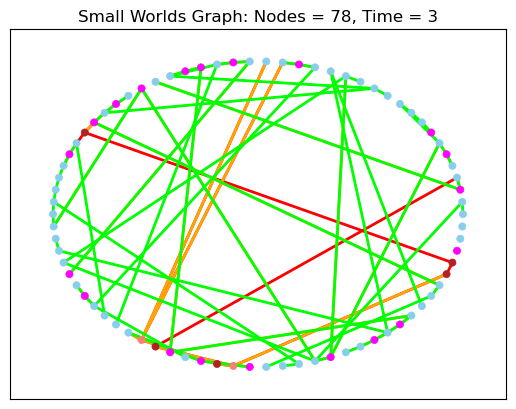

 30%|█████████████▏                              | 3/10 [00:00<00:00,  7.44it/s]

 40%|█████████████████▌                          | 4/10 [00:00<00:00,  6.97it/s]

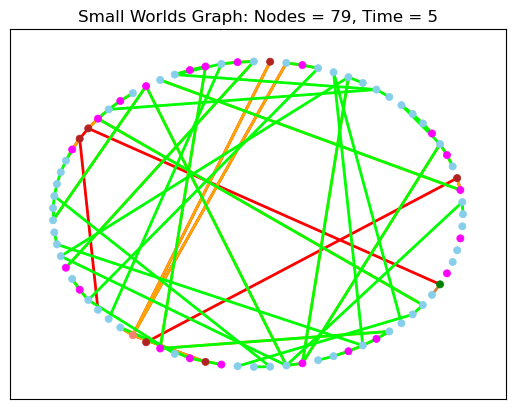

 50%|██████████████████████                      | 5/10 [00:00<00:00,  5.95it/s]

 60%|██████████████████████████▍                 | 6/10 [00:01<00:00,  5.08it/s]

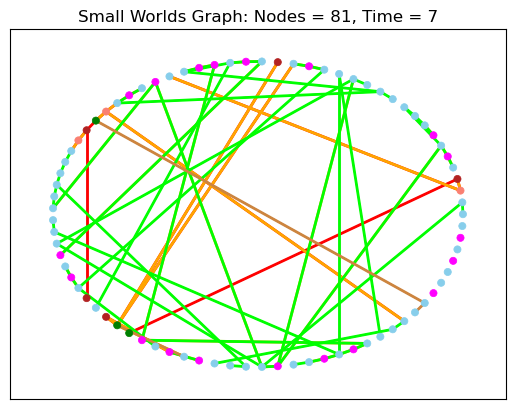

 70%|██████████████████████████████▊             | 7/10 [00:01<00:00,  5.29it/s]

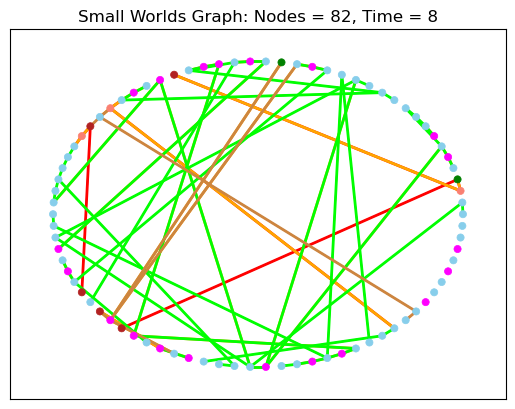

 80%|███████████████████████████████████▏        | 8/10 [00:01<00:00,  5.69it/s]

 90%|███████████████████████████████████████▌    | 9/10 [00:01<00:00,  6.03it/s]

100%|███████████████████████████████████████████| 10/10 [00:01<00:00,  6.07it/s]


In [61]:
# Do this by checking for tuple, if mitigation probability is tuple than mitigation is directional
# Probability has to be established through weights
# weights = 1/p 
# So when determining if disease propagates do 1/weight


class Pandemic_Network():
    
    def __init__(self, network_type: str, nodes: int, pandemicprob: float, mitigation_info = None, NIP = 3, RP = 0, sicknode = 0, SW_connections = 3, SW_randomness = 0.5, SF_k = 1, plots = False, TTR = 15, cum_mit = False):
        '''
        mitigation_info - list: [Proportion that mitigate, Probability of mitigation not working, Start Time, 
                                End Time]. If probability of mitigation not working is a tuple, then implement 
                                directional mitigation. The first value in tuple is for healthy and second is 
                                for infected node.
        sicknodes - number of sick nodes to begin with
        TTR - Time to recover
        RP - Reinfect Probability - probability of being susceptable to reinfection default is 0 i.e. no reinfection
        NIP - Non-Infectious Period
        '''

        if network_type == 'Ring': # default is a ring network
            self.g = nx.watts_strogatz_graph(n = nodes, k = SW_connections, p = 0, seed=None)
        elif network_type == 'Small World':
            self.g = nx.watts_strogatz_graph(n = nodes, k = SW_connections, p = SW_randomness, seed=None)
        elif network_type == 'Scale Free':
            self.g = nx.barabasi_albert_graph(n = nodes, m = SF_k, seed=None, initial_graph=None) # m = Number of edges to attach from a new node to existing nodes
        else:
            self.g = nx.erdos_renyi_graph(n = nodes, p = 0.5, seed=None, directed=False) # if network type not specified, then generate random graph (erdos renyi model)

        #self.pos = nx.circular_layout(self.g)
        self.n = nodes
        self.t = 0
        self.p = pandemicprob
        self.want_plots = plots

        #Mitigations
        if mitigation_info != None:  # if mitigations
            self.mitstart = mitigation_info[2]
            self.mitend = mitigation_info[3]
            self.mitproportion = mitigation_info[0]
            if type(mitigation_info[1]) == tuple:
                self.p_effective_healthy, self.p_effective_infected = mitigation_info[1]
                self.directional = True
            else:
                self.p_effective = mitigation_info[1]
                self.directional = False
        
        self.mitigating = set([])
        self.cum_mit = cum_mit

        
        #Sick nodes
        self.sicknodes = set([random.randint(0, nodes-1) for i in range(sicknode)]) # randomly generate n number of sicknnode
        self.recovered = set([])
        self.TTR = TTR # days to recover, default is 15, customisable dependent on model
        
        #Reinfection
        self.NIP = NIP  # 
        self.RP = RP
        
        # initialise TTR
        initial_TTR_vals = [0 if i not in self.sicknodes else TTR + 1 for i in range(nodes)]
        initial_TTR_dict = {i:initial_TTR_vals[i] for i in range(nodes)}
        nx.set_node_attributes(self.g, initial_TTR_dict, name = 'TTR')
        
        # initialise RP
        initial_NIP_vals = [0 if i not in self.recovered else NIP + 1 for i in range(nodes)]
        initial_NIP_dict = {i:initial_NIP_vals[i] for i in range(nodes)}
        nx.set_node_attributes(self.g, initial_NIP_dict, name = 'NIP')
        # TO Perform reinfection - just introduce a new weight to allow reinfected edges. This weight can be 
        # the probability of infection normally * the probability of reinfection
        
        #Re 
        self.R = dict()
        for node in self.sicknodes:
            self.R[node] = 0 # initialise the infected nodes to having infected 0 other nodes
        self.Rt = []
    
    def plot(self):
        self.pos = nx.circular_layout(self.g)
        node_colors = ["green" if node in self.recovered else 'salmon' if node in self.mitigating and node in self.sicknodes else 'magenta' if node in self.mitigating else "firebrick" if node in self.sicknodes else "skyblue" for node in self.g.nodes()]
        nx.draw_networkx(self.g, pos = self.pos, with_labels=False, node_size=2000/self.n, node_color=node_colors, linewidths=0.5)

        e_no_mit = [(u, v) for (u, v, d) in self.g.edges(data=True) if d["weight"] == self.p]
        e_mit = [(u, v) for (u, v, d) in self.g.edges(data=True) if u in self.mitigating or v in self.mitigating]
        e_sus = [(u, v) for (u, v, d) in self.g.edges(data=True) if d["weight"] == 0]
        e_rp = [(u,v) for (u, v, d) in self.g.edges(data=True) if d["weight"] == self.p*self.RP]
        nx.draw_networkx_edges(self.g, self.pos, edgelist=e_no_mit, width=2, edge_color='red') # un-mitigating
        nx.draw_networkx_edges(self.g, self.pos, edgelist=e_mit, width=2, edge_color='orange') # mitigating
        nx.draw_networkx_edges(self.g, self.pos, edgelist=e_sus, width=2, edge_color='lime') # susceptible
        nx.draw_networkx_edges(self.g, self.pos, edgelist=e_rp, width=2, edge_color='peru') # Reinfected

        
        plt.title("Small Worlds Graph: Nodes = "+ str(len(self.g.nodes()))+ ", Time = " + str(self.t))
        plt.show()
        return
    
    #def sicknode
    def propagate(self, steps: int, populationgrowth = 0, fatalityrate = 0):
        growthrate = populationgrowth/steps
        self.fatalityprob = fatalityrate/self.TTR
        self.newnodes = growthrate*self.n    # number of new nodes to add each step
        nodecounter = self.n
        print(self.newnodes)
        if self.directional:
            timestamps = []
            infectious_count = []
            recovery_count = []
            uninfected_count = []
            cumulative_case_count = []

            for time in tqdm.tqdm(range(steps)):
                # Adding new nodes
                for i in range(int(self.newnodes)):
                    label = nodecounter
                    self.g.add_node(label)
                    nx.set_node_attributes(self.g, {label:0}, name = 'TTR')
                    nx.set_node_attributes(self.g, {label:0}, name = 'NIP')
                    
                    #Check if new node should be mitigating
                    if random.random() < self.mitproportion:
                        self.mitigating.add(label)
                    
                    #Check if new node has any edges with a sick node
                    neighbours = list(self.g.neighbors(label))
                    for j in neighbours:
                        if j in self.sicknodes:
                            if j in self.mitigating:
                                self.g.add_edge(label, j, weight = self.p*self.p_effective_infected)
                                
                            elif label in self.mitigating:
                                self.g.add_edge(label, j, weight = self.p*self.p_effective_healthy)
                            
                            else:
                                self.g.add_edge(label, j, weight = self.p)
                    nodecounter += 1
                    
                    
                #check sick nodes
                new_sick = 0
                timestamps.append(time)
                # print('Time = ', time)
                # print([self.g.nodes[i]['TTR'] for i in range(len(list(self.g.nodes)))])
                # print('Infectious:', self.sicknodes)
                # print('Recovered:', self.recovered)
                if time == 0:
                    cumulative_case_count.append(len(self.sicknodes))

                    # initialise edge weights
                    edge_list = [(u, v) for (u, v, d) in self.g.edges(data = True)] # all edges
                    for j in edge_list:
                        if (j[0] in self.sicknodes or j[1] in self.sicknodes):
                            self.g.add_edge(j[0], j[1], weight = self.p) 
                        else:
                            self.g.add_edge(j[0], j[1], weight = 0) 


                else: 
                    pass

                if time == self.mitstart:
                    while len(self.mitigating) < int(self.n*self.mitproportion):
                        self.mitigating.add(random.choice(list(self.g.nodes())))

                if time == self.mitend:
                    self.mitigating = []

                infectious_count.append(len(self.sicknodes))
                recovery_count.append(len(self.recovered))
                uninfected_count.append(self.n - len(self.recovered) - len(self.sicknodes))

                currentsick = copy.copy(self.sicknodes) #as new sick nodes may be created and we don't want to loop through the new ones

                for i in list(self.g.nodes):

                    #Checking TTR
                    if self.g.nodes[i]['TTR'] - 1 == 0: # end of infectious period
                        self.sicknodes.remove(i)
                        self.recovered.add(i)
                        nx.set_node_attributes(self.g, {i:self.NIP + 1}, name = 'NIP') # initialise infectious node
                        nx.set_node_attributes(self.g, {i: 0}, name='TTR') # decrement TTR value

                    elif self.g.nodes[i]['TTR'] == 0: # not infectious, no action
                        pass
                    else: # mid infectious period
                        nx.set_node_attributes(self.g, {i: self.g.nodes[i]['TTR'] - 1}, name='TTR') # decrement TTR value    

                    #Checking NIP
                    if self.g.nodes[i]['NIP'] -1 == 0:
                        self.recovered.remove(i)
                        neighbours = list(self.g.neighbors(i))
                        for n in neighbours:
                            self.g.add_edge(i, n, weight = self.RP*self.p)  # after infection, new weights should be probability of infection * probability of reinfection

                        #if i in self.mitigating:
                        #    self.mitigating.remove(i)
                        #else:
                        #    pass
                        nx.set_node_attributes(self.g, {i: 0}, name='NIP') # decrement TTR value

                    elif self.g.nodes[i]['NIP'] == 0: # not non-infectious period, no action
                        pass
                    else:
                        nx.set_node_attributes(self.g, {i: self.g.nodes[i]['NIP'] - 1}, name='NIP') # decrement TTR value    


                for node in currentsick:
                    # Check if node should be removed i.e. it dies
                    if random.random() < self.fatalityprob:  
                        self.g.remove_node(node) # remove node from graph
                        if node in self.sicknodes: # if node hasn't already recovered
                            self.sicknodes.remove(node) # remove node from sicknodes
                        continue # move on to new node
                    
                    neighbours = list(self.g.neighbors(node))
                    #try to propagate sickness
                    for neighbour in neighbours:
                        if neighbour in self.sicknodes or neighbour in self.recovered: # do not infect again if already sick.
                            pass
                        elif node in self.mitigating:
                            if np.random.random() < self.g.get_edge_data(node,neighbour)['weight']*self.p_effective_infected: # infected node mitigating
                                self.sicknodes.add(neighbour)
                                adj_neighbours = list(self.g.neighbors(neighbour)) # access the neighbours of the newly infected node to create new edge weightings.
                                new_sick += 1

                                nx.set_node_attributes(self.g, {neighbour:self.TTR + 1}, name = 'TTR') # initialise infectious node

                                for i in adj_neighbours:    
                                        self.g.add_edge(i, neighbour, weight = self.p)

                        elif neighbour in self.mitigating: # node did not adopt mitigation measure 
                            if np.random.random() < self.g.get_edge_data(node,neighbour)['weight']*self.p_effective_healthy: # healthy node mitigating
                                self.sicknodes.add(neighbour)
                                adj_neighbours = list(self.g.neighbors(neighbour)) # access the neighbours of the newly infected node to create new edge weightings.
                                new_sick += 1

                                nx.set_node_attributes(self.g, {neighbour:self.TTR + 1}, name = 'TTR') # initialise infectious node

                                for i in adj_neighbours:    
                                        self.g.add_edge(i, neighbour, weight = self.p)
                        else: # node not infected
                            if np.random.random() < self.g.get_edge_data(node,neighbour)['weight']:  # no node mitigating
                                self.sicknodes.add(neighbour)
                                adj_neighbours = list(self.g.neighbors(neighbour)) # access the neighbours of the newly infected node to create new edge weightings.
                                new_sick += 1

                                nx.set_node_attributes(self.g, {neighbour:self.TTR + 1}, name = 'TTR') # initialise infectious node

                                for i in adj_neighbours:    
                                        self.g.add_edge(i, neighbour, weight = self.p)

                self.Rt.append((new_sick/len(currentsick))*5) # Can just calculate Rt using this as it is just ratio of new people infected with currently infected nodes
                cumulative_case_count.append(cumulative_case_count[-1] + new_sick)
                self.t += 1 #timestep increase by 1

                if self.want_plots: 
                    self.plot()


                #If no more sick nodes than we can finish propagation
                if len(self.sicknodes) == 0:
                    break
                    
        else: # if not directed mitigation probability of effectiveness
            timestamps = []
            infectious_count = []
            recovery_count = []
            uninfected_count = []
            cumulative_case_count = []
            # Adding new nodes
            for i in range(int(self.newnodes)):
                label = nodecounter
                self.g.add_node(label)
                nx.set_node_attributes(self.g, {label:0}, name = 'TTR')
                nx.set_node_attributes(self.g, {label:0}, name = 'NIP')
                
                #Check if new node should be mitigating
                if random.random() < self.mitproportion:
                    self.mitigating.add(label)
                    
                #Check if new node has any edges with a sick node
                neighbours = list(self.g.neighbors(label))
                for j in neighbours:
                    if j in self.sicknodes:
                        if j in self.mitigating or label in self.mitigating:
                            self.g.add_edge(label, j, weight = self.p*self.p_effective)
                                
                        else:
                            self.g.add_edge(label, j, weight = self.p)
                    nodecounter += 1
                    
            for time in tqdm.tqdm(range(steps)):
                #check sick nodes
                new_sick = 0
                timestamps.append(time)
                # print('Time = ', time)
                # print([self.g.nodes[i]['TTR'] for i in range(len(list(self.g.nodes)))])
                # print('Infectious:', self.sicknodes)
                # print('Recovered:', self.recovered)
                if time == 0:
                    cumulative_case_count.append(len(self.sicknodes))

                    # initialise edge weights
                    edge_list = [(u, v) for (u, v, d) in self.g.edges(data = True)] # all edges
                    for j in edge_list:
                        if (j[0] in self.sicknodes or j[1] in self.sicknodes):
                            self.g.add_edge(j[0], j[1], weight = self.p) 
                        else:
                            self.g.add_edge(j[0], j[1], weight = 0) 

                    # self.plot()

                else: 
                    pass

                if time == self.mitstart:
                    while len(self.mitigating) < int(self.n*self.mitproportion):
                        self.mitigating.add(random.choice(list(self.g.nodes())))

                if time == self.mitend:
                    self.mitigating = []

                infectious_count.append(len(self.sicknodes))
                recovery_count.append(len(self.recovered))
                uninfected_count.append(self.n - len(self.recovered) - len(self.sicknodes))

                currentsick = copy.copy(self.sicknodes) #as new sick nodes may be created and we don't want to loop through the new ones

                for i in range(len(list(self.g.nodes))):

                    #Checking TTR
                    if self.g.nodes[i]['TTR'] - 1 == 0: # end of infectious period
                        self.sicknodes.remove(i)
                        self.recovered.add(i)
                        nx.set_node_attributes(self.g, {i:self.NIP + 1}, name = 'NIP') # initialise infectious node
                        nx.set_node_attributes(self.g, {i: 0}, name='TTR') # decrement TTR value

                    elif self.g.nodes[i]['TTR'] == 0: # not infectious, no action
                        pass
                    else: # mid infectious period
                        nx.set_node_attributes(self.g, {i: self.g.nodes[i]['TTR'] - 1}, name='TTR') # decrement TTR value    

                    #Checking NIP
                    if self.g.nodes[i]['NIP'] -1 == 0:
                        self.recovered.remove(i)
                        neighbours = list(self.g.neighbors(i))
                        for n in neighbours:
                            self.g.add_edge(i, n, weight = self.RP*self.p)  # after infection, new weights should be probability of infection * probability of reinfection

                        #if i in self.mitigating:
                        #    self.mitigating.remove(i)
                        #else:
                        #    pass
                        nx.set_node_attributes(self.g, {i: 0}, name='NIP') # decrement TTR value

                    elif self.g.nodes[i]['NIP'] == 0: # not non-infectious period, no action
                        pass
                    else:
                        nx.set_node_attributes(self.g, {i: self.g.nodes[i]['NIP'] - 1}, name='NIP') # decrement TTR value    


                for node in currentsick:
                    # Check if node should be removed i.e. it dies
                    if random.random() < self.fatalityprob:  
                        self.g.remove_node(node) # remove node from graph
                        self.sicknodes.remove(node) # remove node from sicknodes
                        continue # move on to new node
                    
                    neighbours = list(self.g.neighbors(node))

                    #try to propagate sickness
                    for neighbour in neighbours:

                        if neighbour in self.sicknodes or neighbour in self.recovered: # do not infect again if already sick.
                            pass
                        elif node in self.mitigating or neighbour in self.mitigating:
                            if np.random.random() < self.g.get_edge_data(node,neighbour)['weight']*self.p_effective: # new node infected
                                self.sicknodes.add(neighbour)
                                adj_neighbours = list(self.g.neighbors(neighbour)) # access the neighbours of the newly infected node to create new edge weightings.
                                new_sick += 1

                                nx.set_node_attributes(self.g, {neighbour:self.TTR + 1}, name = 'TTR') # initialise infectious node

                                for i in adj_neighbours:    
                                    self.g.add_edge(i, neighbour, weight = self.p)

                        else: # node not infected
                            if np.random.random() < self.g.get_edge_data(node,neighbour)['weight']: # new node infected
                                self.sicknodes.add(neighbour)
                                adj_neighbours = list(self.g.neighbors(neighbour)) # access the neighbours of the newly infected node to create new edge weightings.
                                new_sick += 1

                                nx.set_node_attributes(self.g, {neighbour:self.TTR + 1}, name = 'TTR') # initialise infectious node

                                for i in adj_neighbours:    
                                    self.g.add_edge(i, neighbour, weight = self.p)

                self.Rt.append((new_sick/len(currentsick))*self.TTR) # Can just calculate Rt using this as it is just ratio of new people infected with currently infected nodes
                cumulative_case_count.append(cumulative_case_count[-1] + new_sick)
                self.t += 1 #timestep increase by 1

                if self.want_plots: 
                    self.plot()


                #If no more sick nodes than we can finish propagation
                if len(self.sicknodes) == 0:
                    break
                
        # self.plot()             
        return timestamps, infectious_count, recovery_count, uninfected_count, cumulative_case_count[:-1], self.Rt
    
    
# Testing the class
num_nodes = 75
num_sick = 2
avg_connection = 3
randomness = 0.5
TTR_val = 3
NIP = 1
RP = 0.5
p = 0.6
mitigation = [0.3, (0.8, 0.5), 2, 8]
RP = 0.5
ntype = 'Small World'

G_data = Pandemic_Network(network_type = ntype, nodes = num_nodes, pandemicprob = p, mitigation_info = mitigation, NIP = NIP, RP = RP, sicknode = 1, SW_connections = avg_connection, SW_randomness = randomness, plots = True, TTR = TTR_val).propagate(10, 0.15, 0.2)


## Propagation Class for testing Average Shortest Path Length

THIS CLASS DOES NOT WORK FOR REINFECTION CASES 

In [13]:
class Pandemic_Network():
    
    def __init__(self, network_type: str, nodes: int, pandemicprob: float, mitigation_info = None, NIP = 3, RP = 0, sicknode = 0, SW_connections = 3, SW_randomness = 0.5, SF_k = 1, plots = False, TTR = 15, cum_mit = False):
        '''
        mitigation_info - list: [Proportion that mitigate, Probability of mitigation not working, Start Time, 
                                End Time]. If probability of mitigation not working is a tuple, then implement 
                                directional mitigation. The first value in tuple is for healthy and second is 
                                for infected node.
        sicknodes - number of sick nodes to begin with
        TTR - Time to recover
        RP - Reinfect Probability - probability of being susceptable to reinfection default is 0 i.e. no reinfection
        NIP - Non-Infectious Period
        '''

        if network_type == 'Ring': # default is a ring network
            self.g = nx.watts_strogatz_graph(n = nodes, k = SW_connections, p = 0, seed=None)
        elif network_type == 'Small World':
            self.g = nx.watts_strogatz_graph(n = nodes, k = SW_connections, p = SW_randomness, seed=None)
        elif network_type == 'Scale Free':
            self.g = nx.barabasi_albert_graph(n = nodes, m = SF_k, seed=None, initial_graph=None) # m = Number of edges to attach from a new node to existing nodes
        else:
            self.g = nx.erdos_renyi_graph(n = nodes, p = 0.5, seed=None, directed=False) # if network type not specified, then generate random graph (erdos renyi model)

        #self.pos = nx.circular_layout(self.g)
        self.n = nodes
        self.t = 0
        self.p = pandemicprob
        self.want_plots = plots

        #Mitigations
        if mitigation_info != None:  # if mitigations
            self.mitstart = mitigation_info[2]
            self.mitend = mitigation_info[3]
            self.mitproportion = mitigation_info[0]
            if type(mitigation_info[1]) == tuple:
                self.p_effective_healthy, self.p_effective_infected = mitigation_info[1]
                self.directional = True
            else:
                self.p_effective = mitigation_info[1]
                self.directional = False
        
        self.mitigating = set([])
        self.cum_mit = cum_mit

        
        #Sick nodes
        self.sicknodes = set([random.randint(0, nodes-1) for i in range(sicknode)]) # randomly generate n number of sicknnode
        self.recovered = set([])
        self.TTR = TTR # days to recover, default is 15, customisable dependent on model
        
        #Reinfection
        self.NIP = NIP   
        self.RP = RP
        
        # initialise TTR
        initial_TTR_vals = [0 if i not in self.sicknodes else TTR + 1 for i in range(nodes)]
        initial_TTR_dict = {i:initial_TTR_vals[i] for i in range(nodes)}
        nx.set_node_attributes(self.g, initial_TTR_dict, name = 'TTR')
        
        # initialise RP
        initial_NIP_vals = [0 if i not in self.recovered else NIP + 1 for i in range(nodes)]
        initial_NIP_dict = {i:initial_NIP_vals[i] for i in range(nodes)}
        nx.set_node_attributes(self.g, initial_NIP_dict, name = 'NIP')
        # TO Perform reinfection - just introduce a new weight to allow reinfected edges. This weight can be 
        # the probability of infection normally * the probability of reinfection
        
        #Re 
        self.R = dict()
        for node in self.sicknodes:
            self.R[node] = 0 # initialise the infected nodes to having infected 0 other nodes
        self.Rt = []
    
    def plot(self):
        self.pos = nx.circular_layout(self.g)
        node_colors = ["green" if node in self.recovered else 'salmon' if node in self.mitigating and node in self.sicknodes else 'magenta' if node in self.mitigating else "firebrick" if node in self.sicknodes else "skyblue" for node in self.g.nodes()]
        nx.draw_networkx(self.g, pos = self.pos, with_labels=False, node_size=2000/self.n, node_color=node_colors, linewidths=0.5)

        e_no_mit = [(u, v) for (u, v, d) in self.g.edges(data=True) if d["weight"] == self.p]
        e_mit = [(u, v) for (u, v, d) in self.g.edges(data=True) if u in self.mitigating or v in self.mitigating]
        e_sus = [(u, v) for (u, v, d) in self.g.edges(data=True) if d["weight"] == 0]
        e_rp = [(u,v) for (u, v, d) in self.g.edges(data=True) if d["weight"] == self.p*self.RP]
        nx.draw_networkx_edges(self.g, self.pos, edgelist=e_no_mit, width=2, edge_color='red') # un-mitigating
        nx.draw_networkx_edges(self.g, self.pos, edgelist=e_mit, width=2, edge_color='orange') # mitigating
        nx.draw_networkx_edges(self.g, self.pos, edgelist=e_sus, width=2, edge_color='lime') # susceptible
        nx.draw_networkx_edges(self.g, self.pos, edgelist=e_rp, width=2, edge_color='peru') # Reinfected

        
        plt.title("Small Worlds Graph: Nodes = "+ str(len(self.g.nodes()))+ ", Time = " + str(self.t))
        plt.show()
        return
    
    #def sicknode
    def propagate(self, steps: int, populationgrowth = 0, fatalityrate = 0):
        growthrate = populationgrowth/steps
        self.fatalityprob = fatalityrate/self.TTR
        self.newnodes = growthrate*self.n    # number of new nodes to add each step
        nodecounter = self.n
        time = 0
        if self.directional:
            timestamps = []
            infectious_count = []
            recovery_count = []
            uninfected_count = []
            cumulative_case_count = []

            while len(self.sicknodes) > 0:
                print(len(self.sicknodes))
                # Adding new nodes
                for i in range(int(self.newnodes)):
                    label = nodecounter
                    self.g.add_node(label)
                    nx.set_node_attributes(self.g, {label:0}, name = 'TTR')
                    nx.set_node_attributes(self.g, {label:0}, name = 'NIP')
                    
                    #Check if new node should be mitigating
                    if random.random() < self.mitproportion and self.mitend < time < self.mitstart:
                        self.mitigating.add(label)
                    
                    #Check if new node has any edges with a sick node
                    neighbours = list(self.g.neighbors(label))
                    for j in neighbours:
                        if j in self.sicknodes and j in self.mitigating: # if the mitigating node is sick then multiply by p_effective_infected
                            nx.add_edge(label, j, weight = 1/(self.p*self.p_effective_infected))
                        
                        elif label in self.mitigating or j in self.mitigating:
                            nx.add_edge(label, j, weight = 1/(self.p*self.p_effective_healthy))
                            
                        # If j is sick and mitigating than use peffective infected, if j or label mitigating than 
                        # weight will be healthy for now, if no one is mitigating than weight is self.p
                        else:
                            nx.add_edge(label, j, weight = 1/(self.p))

                    nodecounter += 1
                    
                    
                #check sick nodes
                new_sick = 0
                timestamps.append(time)
                # print('Time = ', time)
                # print([self.g.nodes[i]['TTR'] for i in range(len(list(self.g.nodes)))])
                # print('Infectious:', self.sicknodes)
                # print('Recovered:', self.recovered)
                if time == 0:
                    cumulative_case_count.append(len(self.sicknodes))

                    # initialise edge weights
                    edge_list = [(u, v) for (u, v, d) in self.g.edges(data = True)] # all edges
                    for j in edge_list:
                        self.g.add_edge(j[0], j[1], weight = 1/self.p) # initially all edges have weight of 1/p


                else: 
                    pass

                if time == self.mitstart:
                    while len(self.mitigating) < int(self.n*self.mitproportion):
                        self.mitigating.add(random.choice(list(self.g.nodes())))
                    
                    
                    for i in self.mitigating:
                        neighbours = list(self.g.neighbors(i))
                        
                        # For mitigating node check each neighbour
                        for j in neighbours:
                            if i in self.sicknodes: # if the mitigating node is sick then multiply by p_effective_infected
                                oldweight = self.g.get_edge_data(i,j)['weight']
                                oldweight = 1/oldweight
                                nx.set_edge_attributes(self.g, {(i,j): 1/(oldweight*self.p_effective_infected)}, 'weight')
                            
                            # If neighbour is sick than probability will be reduced by self.p_effective_healthy,
                            # unless neighbour node is also mitigating, in which case just skip and wait till
                            # that node is selected in mitigation node set
                            elif j in self.sicknodes and j not in self.mitigating:
                                oldweight = self.g.get_edge_data(i,j)['weight']
                                oldweight = 1/oldweight
                                nx.set_edge_attributes(self.g, {(i,j): 1/(oldweight*self.p_effective_healthy)}, 'weight')

                                
                                    

                if time == self.mitend:
                    for i in self.mitigating:
                        neighbours = list(self.g.neighbors(i))

                        # For mitigating node check each neighbour
                        for j in neighbours:
                            if i in self.sicknodes: 
                                oldweight = self.g.get_edge_data(i,j)['weight']
                                # Since we are just assuming no reinfection, once mitigation removed just set weight back
                                # to 1/self.p for everything
                                nx.set_edge_attributes(self.g, {(i,j): 1/self.p}, 'weight')

                            # If neighbour is sick than probability will be reduced by self.p_effective_healthy,
                            # unless neighbour node is also mitigating, in which case just skip and wait till
                            # that node is selected in mitigation node set
                            elif j in self.sicknodes and j not in self.mitigating:
                                oldweight = self.g.get_edge_data(i,j)['weight']
                                nx.set_edge_attributes(self.g, {(i,j): 1/self.p}, 'weight')

                    self.mitigating = set([])
                    
                infectious_count.append(len(self.sicknodes))
                recovery_count.append(len(self.recovered))
                uninfected_count.append(self.n - len(self.recovered) - len(self.sicknodes))

                currentsick = copy.copy(self.sicknodes) #as new sick nodes may be created and we don't want to loop through the new ones

                for i in list(self.g.nodes):

                    #Checking TTR
                    if self.g.nodes[i]['TTR'] - 1 == 0: # end of infectious period
                        self.sicknodes.remove(i)
                        
                        # Remove edges as disease can no longer propagate to this node as NO REINFECTION
                        neighbors = list(self.g.neighbors(i))
                        for j in neighbors:
                            self.g.remove_edge(i,j)
                            
                        self.recovered.add(i)
                        nx.set_node_attributes(self.g, {i:self.NIP + 1}, name = 'NIP') # initialise infectious node
                        nx.set_node_attributes(self.g, {i: 0}, name='TTR') # decrement TTR value

                    elif self.g.nodes[i]['TTR'] == 0: # not infectious, no action
                        pass
                    else: # mid infectious period
                        nx.set_node_attributes(self.g, {i: self.g.nodes[i]['TTR'] - 1}, name='TTR') # decrement TTR value    

                    #Checking NIP
                    if self.g.nodes[i]['NIP'] -1 == 0:
                        self.recovered.remove(i)
                        neighbours = list(self.g.neighbors(i))
                        for n in neighbours:
                            self.g.add_edge(i, n, weight = self.RP*self.p)  # after infection, new weights should be probability of infection * probability of reinfection

                        #if i in self.mitigating:
                        #    self.mitigating.remove(i)
                        #else:
                        #    pass
                        nx.set_node_attributes(self.g, {i: 0}, name='NIP') # decrement TTR value

                    elif self.g.nodes[i]['NIP'] == 0: # not non-infectious period, no action
                        pass
                    else:
                        nx.set_node_attributes(self.g, {i: self.g.nodes[i]['NIP'] - 1}, name='NIP') # decrement TTR value    


                for node in currentsick:
                    # Check if node should be removed i.e. it dies
                    if random.random() < self.fatalityprob:  
                        if node in self.sicknodes: # if node hasn't already recovered
                            self.sicknodes.remove(node) # remove node from sicknodes
                        
                        # Remove all edges with this node
                        neighbours = list(self.g.neighbors(node))
                        for n in neighbours:
                            self.g.remove_edge(node, n)  # after infection, new weights should be probability of infection * probability of reinfection
                        
                        self.g.remove_node(node) # remove node from graph
                        continue # move on to new node
                    
                    neighbours = list(self.g.neighbors(node))
                    #try to propagate sickness
                    for neighbour in neighbours:
                        if neighbour in self.sicknodes or neighbour in self.recovered: # do not infect again if already sick.
                            pass
                        
                        elif np.random.random() < 1/self.g.get_edge_data(node,neighbour)['weight']: # infected node mitigating
                                self.sicknodes.add(neighbour)
                                new_sick += 1

                                nx.set_node_attributes(self.g, {neighbour:self.TTR + 1}, name = 'TTR') # initialise infectious node
                                
                                
                                
                                adj_neighbours = list(self.g.neighbors(neighbour)) # access the neighbours of the newly infected node to create new edge weightings.
                                for i in adj_neighbours:
                                    if neighbour in self.mitigating:
                                        oldweight = self.g.get_edge_data(i,neighbour)['weight']
                                        nx.set_edge_attributes(self.g, {(i,neighbour): 1/(self.p*self.p_effective_infected)}, 'weight')
                                    elif i in self.mitigating:
                                        oldweight = self.g.get_edge_data(i,neighbour)['weight']
                                        nx.set_edge_attributes(self.g, {(i,neighbour): 1/(self.p*self.p_effective_healthy)}, 'weight')
                                    else:
                                         pass # weight already self.p so doesn't need to change
                        else: 
                            pass

                self.Rt.append((new_sick/len(currentsick))*5) # Can just calculate Rt using this as it is just ratio of new people infected with currently infected nodes
                cumulative_case_count.append(cumulative_case_count[-1] + new_sick)
                time += 1 #timestep increase by 1

                if self.want_plots: 
                    self.plot()


                #If no more sick nodes than we can finish propagation
                if len(self.sicknodes) == 0:
                    break
                    
        else: # if not directed mitigation probability of effectiveness
            timestamps = []
            infectious_count = []
            recovery_count = []
            uninfected_count = []
            cumulative_case_count = []
            
                    
            while len(self.sicknodes) > 0:
                
                # Adding new nodes
                for i in range(int(self.newnodes)):
                    label = nodecounter
                    self.g.add_node(label)
                    nx.set_node_attributes(self.g, {label:0}, name = 'TTR')
                    nx.set_node_attributes(self.g, {label:0}, name = 'NIP')

                    #Check if new node should be mitigating
                    if random.random() < self.mitproportion and self.mitend < time < self.mitstart:
                        self.mitigating.add(label)

                    #Check if new node has any edges with a sick node
                    neighbours = list(self.g.neighbors(label))
                    for j in neighbours:
                        if j in self.sicknodes and j in self.mitigating: # if the mitigating node is sick then multiply by p_effective_infected
                            nx.add_edge(label, j, weight = 1/(self.p*self.p_effective_infected))

                        elif label in self.mitigating or j in self.mitigating:
                            nx.add_edge(label, j, weight = 1/(self.p*self.p_effective_healthy))

                        # If j is sick and mitigating than use peffective infected, if j or label mitigating than 
                        # weight will be healthy for now, if no one is mitigating than weight is self.p
                        else:
                            nx.add_edge(label, j, weight = 1/(self.p))

                    nodecounter += 1
                    
                #check sick nodes
                new_sick = 0
                timestamps.append(time)
                # print('Time = ', time)
                # print([self.g.nodes[i]['TTR'] for i in range(len(list(self.g.nodes)))])
                # print('Infectious:', self.sicknodes)
                # print('Recovered:', self.recovered)
                if time == 0:
                    cumulative_case_count.append(len(self.sicknodes))

                    # initialise edge weights
                    edge_list = [(u, v) for (u, v, d) in self.g.edges(data = True)] # all edges
                    for j in edge_list:
                        self.g.add_edge(j[0], j[1], weight = 1/self.p) # initially all edges have weight of 1/p


                if time == self.mitstart:
                    while len(self.mitigating) < int(self.n*self.mitproportion):
                        self.mitigating.add(random.choice(list(self.g.nodes())))
                    
                    
                    for i in self.mitigating:
                        neighbours = list(self.g.neighbors(i))
                        
                        # For mitigating node check each neighbour
                        for j in neighbours:
                            if i in self.sicknodes: # if the mitigating node is sick then multiply by p_effective_infected
                                oldweight = self.g.get_edge_data(i,j)['weight']
                                oldweight = 1/oldweight
                                nx.set_edge_attributes(self.g, {(i,j): 1/(oldweight*self.p_effective_infected)}, 'weight')
                            
                            # If neighbour is sick than probability will be reduced by self.p_effective_healthy,
                            # unless neighbour node is also mitigating, in which case just skip and wait till
                            # that node is selected in mitigation node set
                            elif j in self.sicknodes and j not in self.mitigating:
                                oldweight = self.g.get_edge_data(i,j)['weight']
                                oldweight = 1/oldweight
                                nx.set_edge_attributes(self.g, {(i,j): 1/(oldweight*self.p_effective_healthy)}, 'weight')

                if time == self.mitend:
                    for i in self.mitigating:
                        neighbours = list(self.g.neighbors(i))

                        # For mitigating node check each neighbour
                        for j in neighbours:
                            if i in self.sicknodes: 
                                oldweight = self.g.get_edge_data(i,j)['weight']
                                # Since we are just assuming no reinfection, once mitigation removed just set weight back
                                # to 1/self.p for everything
                                nx.set_edge_attributes(self.g, {(i,j): 1/self.p}, 'weight')

                            # If neighbour is sick than probability will be reduced by self.p_effective_healthy,
                            # unless neighbour node is also mitigating, in which case just skip and wait till
                            # that node is selected in mitigation node set
                            elif j in self.sicknodes and j not in self.mitigating:
                                oldweight = self.g.get_edge_data(i,j)['weight']
                                nx.set_edge_attributes(self.g, {(i,j): 1/self.p}, 'weight')

                    self.mitigating = set([])

                infectious_count.append(len(self.sicknodes))
                recovery_count.append(len(self.recovered))
                uninfected_count.append(self.n - len(self.recovered) - len(self.sicknodes))

                currentsick = copy.copy(self.sicknodes) #as new sick nodes may be created and we don't want to loop through the new ones

                for i in range(len(list(self.g.nodes))):

                    #Checking TTR
                    if self.g.nodes[i]['TTR'] - 1 == 0: # end of infectious period
                        self.sicknodes.remove(i)
                        
                        # Remove edges as disease can no longer propagate to this node as NO REINFECTION
                        neighbors = list(self.g.neighbors(i))
                        for j in neighbors:
                            self.g.remove_edge(i,j)
                            
                        self.recovered.add(i)
                        nx.set_node_attributes(self.g, {i:self.NIP + 1}, name = 'NIP') # initialise infectious node
                        nx.set_node_attributes(self.g, {i: 0}, name='TTR') # decrement TTR value

                    elif self.g.nodes[i]['TTR'] == 0: # not infectious, no action
                        pass
                    else: # mid infectious period
                        nx.set_node_attributes(self.g, {i: self.g.nodes[i]['TTR'] - 1}, name='TTR') # decrement TTR value    

                    #Checking NIP
                    if self.g.nodes[i]['NIP'] -1 == 0:
                        self.recovered.remove(i)
                        neighbours = list(self.g.neighbors(i))
                        for n in neighbours:
                            self.g.add_edge(i, n, weight = self.RP*self.p)  # after infection, new weights should be probability of infection * probability of reinfection

                        #if i in self.mitigating:
                        #    self.mitigating.remove(i)
                        #else:
                        #    pass
                        nx.set_node_attributes(self.g, {i: 0}, name='NIP') # decrement TTR value

                    elif self.g.nodes[i]['NIP'] == 0: # not non-infectious period, no action
                        pass
                    else:
                        nx.set_node_attributes(self.g, {i: self.g.nodes[i]['NIP'] - 1}, name='NIP') # decrement TTR value    


                for node in currentsick:
                    # Check if node should be removed i.e. it dies
                    if random.random() < self.fatalityprob:  
                        if node in self.sicknodes:
                            self.sicknodes.remove(node) # remove node from sicknodes
                            
                        # Remove all edges with this node
                        neighbours = list(self.g.neighbors(node))
                        for n in neighbours:
                            self.g.remove_edge(node, n)  # after infection, new weights should be probability of infection * probability of reinfection
                        
                        self.g.remove_node(node) # remove node from graph
                        continue # move on to new node
                    
                    neighbours = list(self.g.neighbors(node))
                    #try to propagate sickness
                    for neighbour in neighbours:
                        if neighbour in self.sicknodes or neighbour in self.recovered: # do not infect again if already sick.
                            pass
                        
                        elif np.random.random() < 1/self.g.get_edge_data(node,neighbour)['weight']: # infected node mitigating
                                self.sicknodes.add(neighbour)
                                new_sick += 1

                                nx.set_node_attributes(self.g, {neighbour:self.TTR + 1}, name = 'TTR') # initialise infectious node
                                
                                
                                
                                adj_neighbours = list(self.g.neighbors(neighbour)) # access the neighbours of the newly infected node to create new edge weightings.
                                for i in adj_neighbours:
                                    if neighbour in self.mitigating:
                                        oldweight = self.g.get_edge_data(i,neighbour)['weight']
                                        nx.set_edge_attributes(self.g, {(i,neighbour): 1/(self.p*self.p_effective_infected)}, 'weight')
                                    elif i in self.mitigating:
                                        oldweight = self.g.get_edge_data(i,neighbour)['weight']
                                        nx.set_edge_attributes(self.g, {(i,neighbour): 1/(self.p*self.p_effective_healthy)}, 'weight')
                                    else:
                                         pass # weight already self.p so doesn't need to change
                        else: 
                            pass
                        
                self.Rt.append((new_sick/len(currentsick))*self.TTR) # Can just calculate Rt using this as it is just ratio of new people infected with currently infected nodes
                cumulative_case_count.append(cumulative_case_count[-1] + new_sick)
                time += 1 #timestep increase by 1

                if self.want_plots: 
                    self.plot()


                #If no more sick nodes than we can finish propagation
                if len(self.sicknodes) == 0:
                    break
                
        # self.plot()             
        return timestamps, infectious_count, recovery_count, uninfected_count, cumulative_case_count[:-1], self.Rt
    
    
# Testing the class
num_nodes = 10000
num_sick = 1
avg_connection = 5
randomness = 0.5
TTR_val = 10
NIP = 1
p = 0.25
mitigation = [0.3, (0.7, 0.2), 10, 15]
RP = 0
ntype = 'Small World'

G_data = Pandemic_Network(network_type = ntype, nodes = num_nodes, pandemicprob = p, mitigation_info = mitigation, NIP = NIP, RP = RP, sicknode = 1, SW_connections = avg_connection, SW_randomness = randomness, plots = False, TTR = TTR_val).propagate(10, 0, 0)


1
2
4
6
7
10
16
28
49
73
110
146
204
284
392
545
850
1280
1921
2783
3855
5041
6335
7413
8255
8798
9032
8918
8584
7982
7137
6052
4837
3509
2377
1453
801
413
219
117
66
28
17
9
6
1
1


In [16]:
g = nx.barabasi_albert_graph(100, m= 3/2)

TypeError: 'float' object is not iterable